<a href="https://colab.research.google.com/github/Luanpedro21/AulaBanco/blob/master/Article_Detection_SUGARCANE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!fusermount -u /content/drive
!rm -rf /content/drive

fusermount: failed to unmount /content/drive: No such file or directory


### Library installation and connection to Google Drive

In [6]:
!pip install rasterio
!pip install PyWavelets
!pip install opencv-contrib-python
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.8 MB/s eta 0:00:00


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Ler o CSV
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_balanced.csv")

# Exibir a contagem de objetos por classe
print(df['CLASS'].value_counts())

CLASS
SUGARCANE    2913
OTHERS       2913
SOYBEAN      2913
Name: count, dtype: int64


In [ ]:
import os
os.listdir("/content/drive/MyDrive/sistema_etec")

['css', 'assets', 'php']

In [ ]:
import os

base_path = "/content/drive/MyDrive"

def scan_directory(path, depth=1):
    try:
        print(f"\n📂 Explorando: {path}")
        entries = os.listdir(path)
        for i, entry in enumerate(entries):
            if i >= 20:
                print("⚠️ Mais de 20 itens... parada para evitar travamento.")
                break
            full_path = os.path.join(path, entry)
            if os.path.isdir(full_path):
                print(f"📁 [DIR] {entry}")
                if depth > 0:
                    scan_directory(full_path, depth=depth-1)
            else:
                print(f"📄 {entry}")
    except Exception as e:
        print(f"❌ Erro ao acessar {path}: {e}")

scan_directory(base_path, depth=2)



📂 Explorando: /content/drive/MyDrive
📄 algoritmo profundidade - exercicio.gsheet
📄 exercicio.gsheet
📄 GSO 2ETIA - 2ºBIMESTRE.xls.gsheet
📄 43141208289097000106550010000597551005104158-nfe.pdf
📄 Modelo.gdoc
📄 QUADRO HORARIO INFORMÁTICA - 2SEM.xlsx
📄 QUADRO HORARIO INFORMÁTICA - 2SEM (1).xlsx.gsheet
📄 QUADRO HORARIO INFORMÁTICA - 2SEM.gsheet
📄 QUADRO HORARIO INFORMÁTICA - 2SEM.xlsx.gsheet
📄 enfermagem-Prova-1bim.docx
📄 enfermagem-Prova-1bim.docx.gdoc
📄 PC1-Prova-1bim.docx
📄 PC1-Prova-1bim.docx.gdoc
📄 Desktop.rar
📄 trabalhoDeskchico.rar
📄 ProjetoFinal.rar
📄 luan.jpg
📄 Planilha sem título (2).gsheet
📄 Planilha sem título (1).gsheet
📄 Licenciatura em Computação.rar
⚠️ Mais de 20 itens... parada para evitar travamento.


### Preprocessing and Testing on an Image Crop

Preliminary tests were conducted on a cropped region of the original image in order to validate the procedures prior to applying them in the final pipeline.



NDVI Generation and Binarization of Sugarcane Regions

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure

# ========================
# 1. Load Image and Bands
# ========================
image_path = "/content/drive/MyDrive/Article_SugarCane/cropped_image.tif"

with rasterio.open(image_path) as src:
    red = src.read(3).astype('float32')  # Band 4: Red
    nir = src.read(4).astype('float32')  # Band 8: NIR
    profile = src.profile.copy()

# Normalize if needed
red /= 10000
nir /= 10000

# ========================
# 2. Compute NDVI
# ========================
eps = 1e-10
ndvi = (nir - red) / (nir + red + eps)

plt.figure(figsize=(10, 8))
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='NDVI')
plt.title('NDVI Map')
plt.axis('off')
plt.show()

# ========================
# 3. Create Dense Vegetation Mask
# ========================
ndvi_threshold = 0.6
dense_vegetation_mask = ndvi > ndvi_threshold

plt.figure(figsize=(8, 6))
plt.imshow(dense_vegetation_mask, cmap='gray')
plt.title('Dense Vegetation Mask (NDVI > 0.6)')
plt.axis('off')
plt.show()

# ========================
# 4. Label Connected Objects
# ========================
labeled_array, num_features = ndimage.label(dense_vegetation_mask)
print(f"Total number of detected objects (dense vegetation): {num_features}")

# ========================
# 5. Filter by Area and Compactness
# ========================
props = measure.regionprops(labeled_array)

valid_objects = []
min_area_pixels = 500        # 500 pixels (10m resolution ≈ 5 hectares)
min_compactness = 0.02       # Reasonable compactness threshold

for prop in props:
    area = prop.area
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    if (area > min_area_pixels) and (compactness > min_compactness):
        valid_objects.append(prop.label)

# Create final mask
sugarcane_mask = np.isin(labeled_array, valid_objects)

plt.figure(figsize=(10, 8))
plt.imshow(sugarcane_mask, cmap='gray')
plt.title('Likely Sugarcane Regions')
plt.axis('off')
plt.show()

# ========================
# 6. Count Objects and Compute Area
# ========================
num_sugarcane = len(valid_objects)
num_non_sugarcane = num_features - num_sugarcane

total_area_pixels = sum([prop.area for prop in props if prop.label in valid_objects])
total_area_ha = (total_area_pixels * 100) / 10000  # Each pixel = 10m x 10m = 100 m²

print(f"\nLikely Sugarcane Objects: {num_sugarcane}")
print(f"Likely Non-Sugarcane Objects: {num_non_sugarcane}")
print(f"Estimated Total Sugarcane Area: {total_area_ha:.2f} hectares")

# ========================
# 7. Save Mask as GeoTIFF
# ========================
output_path = "/content/sugarcane_regions_detected.tif"

profile.update(
    driver='GTiff',
    dtype=rasterio.uint8,
    count=1,
    compress='lzw'
)

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(sugarcane_mask.astype('uint8'), 1)

print(f"\nSugarcane region map saved at: {output_path}")


The Guided Filter was applied, followed by the visualization of the images and their corresponding histograms, both before and after filtering.

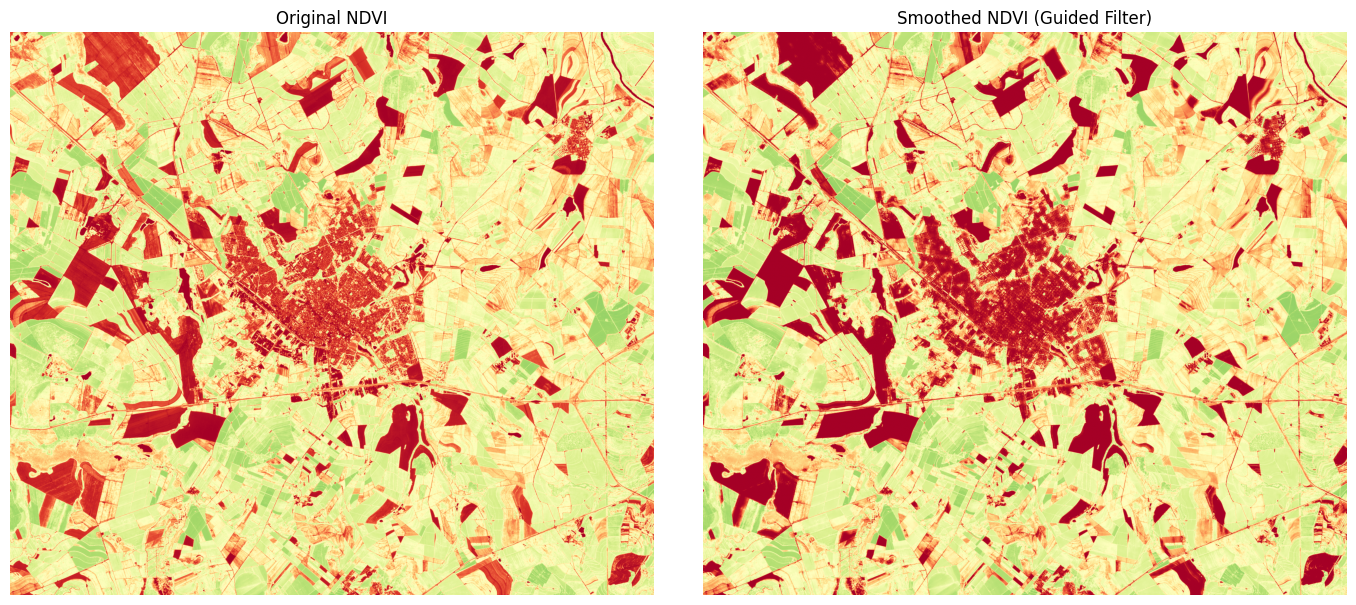

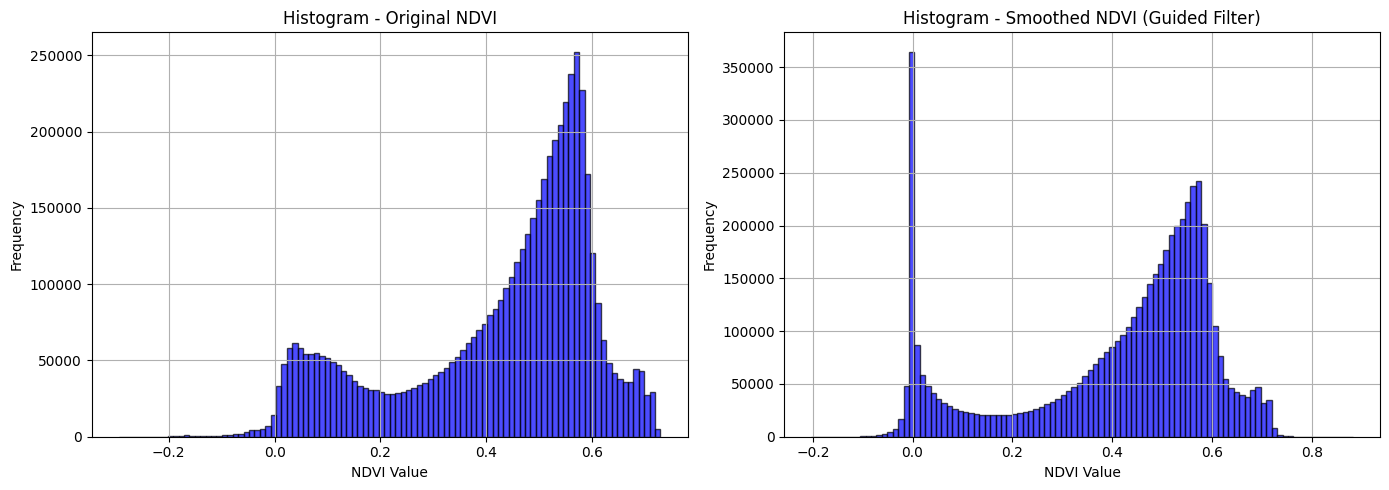

NDVI original, smoothed (Guided Filter), and histograms generated successfully!


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# === Path to Sentinel-2 image containing Red (Band 3) and NIR (Band 4) ===
tif_path = '/content/drive/MyDrive/Article_SugarCane/cropped_image.tif'

# === Open the image ===
with rasterio.open(tif_path) as src:
    red = src.read(3).astype('float32') / 10000  # Band 04 - Red
    nir = src.read(4).astype('float32') / 10000  # Band 08 - NIR
    profile = src.profile
    transform = src.transform
    crs = src.crs

# === Compute NDVI ===
eps = 1e-10
ndvi = (nir - red) / (nir + red + eps)

# === Save original NDVI
ndvi_original = ndvi.copy()

# === Mask for NDVI > 0.2 (vegetation)
valid_mask = ndvi > 0.2
ndvi_filtered = np.where(valid_mask, ndvi, 0)  # replaces NaN with 0 for filtering

# === Apply Guided Filter using the NIR band as guide ===
ndvi_input = ndvi_filtered.astype('float32')
nir_input = nir.astype('float32')

# Guided filter parameters
radius = 5       # window radius (5 → 11x11 window)
eps = 1e-4       # regularization parameter

# Apply guided filter
ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=radius, eps=eps)

# === Side-by-side visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].imshow(ndvi_original, cmap='RdYlGn', vmin=0, vmax=1)
axs[0].set_title('Original NDVI')
axs[0].axis('off')

axs[1].imshow(ndvi_smoothed, cmap='RdYlGn', vmin=0, vmax=1)
axs[1].set_title('Smoothed NDVI (Guided Filter)')
axs[1].axis('off')

plt.tight_layout()
plt.show()

# === Export GeoTIFFs
def save_tiff(name, array, profile):
    profile.update(
        dtype=rasterio.float32,
        count=1,
        compress='lzw',
        nodata=np.nan
    )
    with rasterio.open(name, 'w', **profile) as dst:
        dst.write(array.astype(rasterio.float32), 1)

save_tiff('ndvi_original.tif', ndvi_original, profile)
save_tiff('ndvi_smoothed_guided.tif', ndvi_smoothed, profile)

# === HISTOGRAMS
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for original NDVI
axs[0].hist(ndvi_original[~np.isnan(ndvi_original)].flatten(), bins=100, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title("Histogram - Original NDVI")
axs[0].set_xlabel("NDVI Value")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

# Histogram for smoothed NDVI (Guided Filter)
axs[1].hist(ndvi_smoothed[~np.isnan(ndvi_smoothed)].flatten(), bins=100, color='blue', alpha=0.7, edgecolor='black')
axs[1].set_title("Histogram - Smoothed NDVI (Guided Filter)")
axs[1].set_xlabel("NDVI Value")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("NDVI original, smoothed (Guided Filter), and histograms generated successfully!")



Segmentation of Image Objects After Applying NDVI and Guided Filter

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Path to the filtered NDVI GeoTIFF image ===
image_path = 'ndvi_smoothed_guided.tif'

# === Read the NDVI band ===
with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype('float32')
    profile = src.profile
    mask = src.read_masks(1) > 0

# === Valid data mask ===
valid_mask = (mask) & ~np.isnan(ndvi)

# === NDVI classification into 5 categories ===
ndvi_class = np.full(ndvi.shape, -1)
ndvi_class[valid_mask & (ndvi < 0.05)] = 0                 # Water / Cloud / Shadow
ndvi_class[valid_mask & (ndvi >= 0.05) & (ndvi < 0.2)] = 1  # Exposed Soil
ndvi_class[valid_mask & (ndvi >= 0.2) & (ndvi < 0.6)] = 2   # Sparse Vegetation
ndvi_class[valid_mask & (ndvi >= 0.6) & (ndvi < 0.8)] = 3   # Dense Vegetation
ndvi_class[valid_mask & (ndvi >= 0.8)] = 4                  # Very Dense Vegetation

# === RGB colors for each class ===
colors = [
    [0, 0, 255],     # Class 0 - Blue
    [255, 0, 0],     # Class 1 - Red
    [255, 255, 0],   # Class 2 - Yellow
    [0, 150, 0],     # Class 3 - Green
    [0, 50, 0],      # Class 4 - Dark Green
]

# === Generate RGB classification map ===
ndvi_rgb = np.zeros((ndvi.shape[0], ndvi.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    ndvi_rgb[ndvi_class == i] = color
ndvi_rgb[ndvi_class == -1] = [0, 0, 0]  # Black for no-data areas

# === Legend configuration ===
legend_labels = [
    '(a) Water / Cloud / Shadow',
    '(b) Exposed Soil',
    '(c) Sparse Vegetation',
    '(d) Dense Vegetation',
    '(e) Very Dense Vegetation'
]
legend_patches = [
    mpatches.Patch(color=np.array(color)/255, label=label)
    for color, label in zip(colors, legend_labels)
]

# === Plot visualization ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ndvi_rgb)
ax.set_title('NDVI Classification Map')
ax.axis('off')

# Adjust bottom space for the legend
fig.subplots_adjust(bottom=0.15)

# Center the legend below the image
fig.legend(
    handles=legend_patches,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.0),
    ncol=3,
    title='Categories'
)

plt.show()


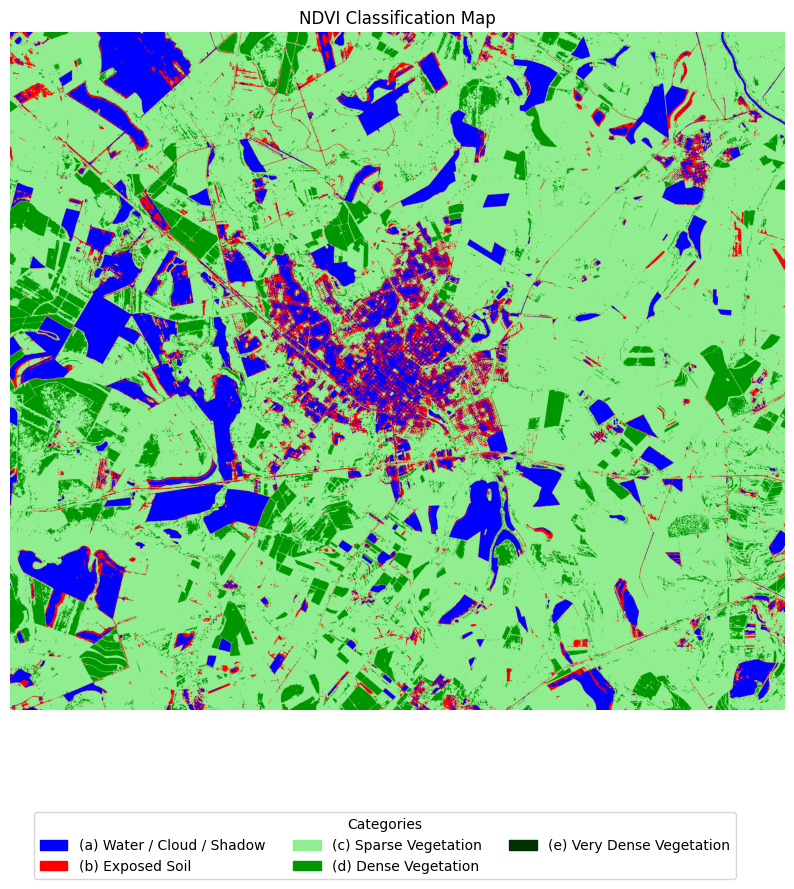

In [ ]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Path to the filtered NDVI GeoTIFF image ===
image_path = 'ndvi_smoothed_guided.tif'

# === Read the NDVI band ===
with rasterio.open(image_path) as src:
    ndvi = src.read(1).astype('float32')
    profile = src.profile
    mask = src.read_masks(1) > 0

# === Valid data mask ===
valid_mask = (mask) & ~np.isnan(ndvi)

# === NDVI classification into 5 categories ===
ndvi_class = np.full(ndvi.shape, -1)
ndvi_class[valid_mask & (ndvi < 0.05)] = 0                 # Water / Cloud / Shadow
ndvi_class[valid_mask & (ndvi >= 0.05) & (ndvi < 0.2)] = 1  # Exposed Soil
ndvi_class[valid_mask & (ndvi >= 0.2) & (ndvi < 0.6)] = 2   # Sparse Vegetation
ndvi_class[valid_mask & (ndvi >= 0.6) & (ndvi < 0.8)] = 3   # Dense Vegetation
ndvi_class[valid_mask & (ndvi >= 0.8)] = 4                  # Very Dense Vegetation

# === RGB colors for each class ===
colors = [
    [0, 0, 255],       # Class 0 - Blue
    [255, 0, 0],       # Class 1 - Red
    [144, 238, 144],   # Class 2 - Light Green (verde claro)
    [0, 150, 0],       # Class 3 - Green
    [0, 50, 0],        # Class 4 - Dark Green
]

# === Generate RGB classification map ===
ndvi_rgb = np.zeros((ndvi.shape[0], ndvi.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    ndvi_rgb[ndvi_class == i] = color
ndvi_rgb[ndvi_class == -1] = [0, 0, 0]  # Black for no-data areas

# === Legend configuration ===
legend_labels = [
    '(a) Water / Cloud / Shadow',
    '(b) Exposed Soil',
    '(c) Sparse Vegetation',
    '(d) Dense Vegetation',
    '(e) Very Dense Vegetation'
]
legend_patches = [
    mpatches.Patch(color=np.array(color)/255, label=label)
    for color, label in zip(colors, legend_labels)
]

# === Plot visualization ===
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ndvi_rgb)
ax.set_title('NDVI Classification Map')
ax.axis('off')

# Adjust bottom space for the legend
fig.subplots_adjust(bottom=0.15)

# Center the legend below the image
fig.legend(
    handles=legend_patches,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.0),
    ncol=3,
    title='Categories'
)

# === Save as EPS ===
plt.savefig("/content/ndvi_classification_map.eps", format="eps")

plt.show()


### FINAL VERSION – THE VERSION USED IN THE MODEL PIPELINE.

Reading images from the soybean folder: In this step, all images from the 'SOYBEAN' folder were read, the previously tested preprocessing techniques were applied, and a CSV file was generated containing data on soybean and non-soybean objects in the images.

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2  # make sure opencv-contrib-python is installed
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import os

# ========================
# 1. Paths
# ========================
image_folder = "/content/drive/MyDrive/Article_SugarCane/SOYBEAN"
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv"

# Create list of images
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
print(f"\nTotal images found: {len(image_list)}")

# Load or create dataset
if os.path.exists(dataset_path):
    print("Existing dataset found. Loading to append new samples...")
    df_final = pd.read_csv(dataset_path)
else:
    print("No existing dataset found. Creating new one...")
    df_final = pd.DataFrame()

# ========================
# 2. Process images
# ========================
for image_path in image_list:
    print(f"\nProcessing: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    # Apply Guided Filter
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    # Convert NDVI to 8-bit for GLCM
    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')

    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    cane_counter = 0
    other_counter = 0
    max_per_class = 1000000

    object_data = []

    for prop in props:
        if cane_counter >= max_per_class and other_counter >= max_per_class:
            break

        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        # GLCM features
        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except Exception as e:
            print(f" GLCM Error: {e}")
            contrast = homogeneity = energy = correlation = np.nan

        # Class labeling
        if (area > 500) and (compactness > 0.02) and cane_counter < max_per_class:
            label = "SOYBEAN"
            cane_counter += 1
        elif other_counter < max_per_class:
            label = "OTHERS"
            other_counter += 1
        else:
            continue

        object_data.append([
            os.path.basename(image_path),
            ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

    # Create partial DataFrame
    columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
               'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
               'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
               'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
               'CLASS']
    df_partial = pd.DataFrame(object_data, columns=columns)
    df_final = pd.concat([df_final, df_partial], ignore_index=True)

# ========================
# 3. Save the dataset
# ========================
df_final.to_csv(dataset_path, index=False)
print(f"\n Dataset successfully updated: {dataset_path}")
print(df_final.head())


Reading images from the SugarCane folder: In this step, all images from the 'SUGARCANE' folder were read, the previously tested preprocessing techniques were applied, and a CSV file was generated containing data on sugarcane and non-sugarcane objects in the image

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import os

# ========================
# 1. Paths
# ========================
image_folder = "/content/drive/MyDrive/Article_SugarCane/SUGARCANE"
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv"

# Create list of image paths
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
print(f"\nTotal images found: {len(image_list)}")

# Load or initialize dataset
if os.path.exists(dataset_path):
    print("Existing dataset found. Loading to append new samples...")
    df_final = pd.read_csv(dataset_path)
else:
    print("No existing dataset. Creating a new one...")
    df_final = pd.DataFrame()

# ========================
# 2. Process each image
# ========================
for image_path in image_list:
    print(f"\nProcessing: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    # Apply Guided Filter
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    # Convert NDVI to 8-bit for GLCM
    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')

    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    count_sugarcane = 0
    count_others = 0
    max_per_class = 1000000

    object_data = []

    for prop in props:
        if count_sugarcane >= max_per_class and count_others >= max_per_class:
            break

        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        # GLCM texture features
        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except Exception as e:
            print(f" Error in GLCM: {e}")
            contrast = homogeneity = energy = correlation = np.nan

        # Class labeling
        if (area > 500) and (compactness > 0.02) and count_sugarcane < max_per_class:
            label = "SUGARCANE"
            count_sugarcane += 1
        elif count_others < max_per_class:
            label = "OTHERS"
            count_others += 1
        else:
            continue

        object_data.append([
            os.path.basename(image_path),
            ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

    # Create DataFrame for current image
    columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
               'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
               'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
               'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
               'CLASS']

    df_partial = pd.DataFrame(object_data, columns=columns)
    df_final = pd.concat([df_final, df_partial], ignore_index=True)

# ========================
# 3. Save dataset
# ========================
df_final.to_csv(dataset_path, index=False)
print(f"\nFinal dataset successfully saved to: {dataset_path}")
print(df_final.head())


Applying DBSCAN to remove noise from the soybean data

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv")

# Filter only soybean objects
df_soybean = df[df['CLASS'] == 'SOYBEAN'].copy()

# Select all numerical features (exclude text/categorical columns)
features = df_soybean.select_dtypes(include=['float64', 'int64']).columns.tolist()
#features.remove('AREA')  # optional: remove if imbalanced
X = df_soybean[features].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)  # adjust if necessary
labels = dbscan.fit_predict(X_scaled)

# Add labels to dataframe
df_soybean['DBSCAN_LABEL'] = labels

# Count how many samples were removed
removed = (labels == -1).sum()
print(f"Soybean samples removed as outliers: {removed}")

# Remove outliers
df_soybean_clean = df_soybean[df_soybean['DBSCAN_LABEL'] != -1].drop(columns='DBSCAN_LABEL')

# Merge with other classes
df_others = df[df['CLASS'] != 'SOYBEAN']
df_clean = pd.concat([df_soybean_clean, df_others], ignore_index=True)

# Save cleaned dataset
df_clean.to_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv", index=False)
print("Dataset saved without outlier soybean samples.")


Showing métrics after remove noises with DBSCAN

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")

# Variables to plot histograms
hist_vars = [
    'NDVI', 'TEXTURE_NDVI', 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY',
    'GLCM_CORRELATION', 'GLCM_ENERGY'
]

# Variables to compute means
mean_vars = hist_vars.copy()

# Class colors
colors = {
    'SUGARCANE': 'green',
    'SOYBEAN': 'yellow'
}

# Plot and export histograms
for var in hist_vars:
    plt.figure(figsize=(8, 5))
    for class_label, color in colors.items():
        if class_label in df['CLASS'].unique():
            subset = df[df['CLASS'] == class_label]
            plt.hist(subset[var], bins=30, alpha=0.6, label=class_label, color=color, edgecolor='white')

    # Titles and labels with larger font sizes
    plt.title(f'Histogram of variable {var}', fontsize=18)
    plt.xlabel(var, fontsize=16)
    plt.ylabel('Frequency', fontsize=16)

    # Legend with larger font
    plt.legend(fontsize=14)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()

    # Save the figure as EPS
    output_path = f"/content/drive/MyDrive/Article_SugarCane/hist_{var}.eps"
    plt.savefig(output_path, format='eps')

    plt.show()




Training the model with the noise removed

In [ ]:
# === Prerequisites
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# === 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")  # adjust path as needed

# === 2. Preprocessing
df = df.dropna()
X = df.drop(columns=["CLASS"])
X = X.iloc[:, 1:]  # remove image/file name column if present
y = df["CLASS"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
label_names = label_encoder.classes_

# === 3. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 4. 2D Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set2", s=60, alpha=0.7)
plt.title("PCA Visualization - 2 Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(False)
plt.legend(title="Class")

# === Save as EPS
plt.savefig("/content/pca_visualization.eps", format="eps")

plt.show()

# === Optional: download if in Google Colab
from google.colab import files
files.download("/content/pca_visualization.eps")




Trainning with Random Forest

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 1. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
print(f"\nDataset loaded with {df_objects.shape[0]} objects.")
print(df_objects['CLASS'].value_counts())

df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]



print("Object count per class:")
print(df_objects['CLASS'].value_counts())

total_sugarcane = (df_objects['CLASS'] == 'SUGARCANE').sum()
print(f"\n Total SUGARCANE objects: {total_sugarcane}")

print("Class values after potential filtering:")
print(df_objects['CLASS'].value_counts())

# ========================
# 2. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

num_nan = df_sugarcane.isna().any(axis=1).sum()
print(f"\n Number of SUGARCANE objects with NaN values: {num_nan}")

print("\n First 10 objects classified as SUGARCANE:")
print(df_sugarcane.head(10))

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

print(f"\nBalanced dataset: {df_balanced.shape[0]} samples.")
print(df_balanced['CLASS'].value_counts())

#df_balanced.head(10)




X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
               'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
               'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
               'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
               ]].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. Grid Search with Random Forest
# ========================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nStarting Grid Search...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\nBest parameter combination: {grid_search.best_params_}")

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['SUGARCANE', 'SOYBEAN', 'OTHERS']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SUGARCANE', 'SOYBEAN', 'OTHERS'],
            yticklabels=['SUGARCANE', 'SOYBEAN', 'OTHERS'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ========================
# 6. Feature Importance
# ========================
importances = best_model.feature_importances_
feature_names = ['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
               'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
               'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
               'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
               ]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
# Evita corte dos nomes e melhora margem esquerda
plt.subplots_adjust(left=0.3)

# Opcional: melhora espaçamento geral
plt.tight_layout()
plt.savefig('/content/feature_importance.eps', format='eps')
plt.show()

# ========================
# 7. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_lite.pkl"
joblib.dump(best_model, model_path)

print(f"\n Model saved at: {model_path}")


#V2

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 1. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

# ========================
# 2. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Prepare data
# ========================
X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
                 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
                 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
                 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY']].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. Grid Search with Random Forest
# ========================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# ========================
# 6. Styled Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for Random Forest Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
ax = sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura10.eps", format="eps")
plt.show()

# ========================
# 7. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_lite.pkl"
joblib.dump(best_model, model_path)
print(f"\nModel saved at: {model_path}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 1. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

# ========================
# 2. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Prepare data (mantendo COMPACTNESS)
# ========================
features = [
    'NDVI', 'STD_NDVI',
    'NIR', 'RED',
    'AREA', 'COMPACTNESS'
]

X = df_balanced[features].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. Grid Search with Random Forest
# ========================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# ========================
# 6. Styled Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for Random Forest Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
ax = sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura10.eps", format="eps")
plt.show()

# ========================
# 7. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_2.pkl"
joblib.dump(best_model, model_path)
print(f"\nModel saved at: {model_path}")


In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'orientation': 'horizontal', 'label': 'Number of Samples'})

Trainning with Support Vector Machine

In [ ]:
# ========================
# 1. Imports
# ========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 2. Load the dataset
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]  # Optional: remove first column (e.g., 'IMAGE')

# Balancing
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Preprocessing
# ========================
df_balanced['LOG_AREA'] = np.log1p(df_balanced['AREA'])

X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
                 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
                 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
                 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY']].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. GridSearchCV with SVM
# ========================
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

clf = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\n Starting Grid Search with SVM...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\n Best parameter combination: {grid_search.best_params_}")

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n Accuracy on test set: {acc:.4f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['SUGARCANE', 'SOYBEAN', 'OTHERS']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['SUGARCANE', 'SOYBEAN', 'OTHERS'],
            yticklabels=['SUGARCANE', 'SOYBEAN', 'OTHERS'])
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ========================
# 6. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/svm_trained.pkl"
joblib.dump(best_model, model_path)

print(f"\n Model saved at: {model_path}")


In [ ]:
# ========================
# 1. Imports
# ========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 2. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

# ========================
# 3. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 4. Prepare data
# ========================
X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
                 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
                 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
                 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY']].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 5. Grid Search with SVM
# ========================
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

clf = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\nStarting Grid Search with SVM...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\nBest parameter combination: {grid_search.best_params_}")

# ========================
# 6. Evaluation
# ========================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# ========================
# 7. Styled Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for Best SVM Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura10_svm_grid.eps", format="eps")
plt.show()

# ========================
# 8. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/svm_grid_trained_model.pkl"
joblib.dump(best_model, model_path)
print(f"\nModel saved at: {model_path}")


In [ ]:
# ========================
# 1. Imports este....
# ========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 2. Load and Balance Dataset
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Preprocessing
# ========================
df_balanced['LOG_AREA'] = np.log1p(df_balanced['AREA'])

X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
                 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
                 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
                 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY']].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. GridSearchCV with SVM
# ========================
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

clf = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("\n Starting Grid Search with SVM...")
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"\n Best parameter combination: {grid_search.best_params_}")

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"\n Accuracy on test set: {accuracy:.4f}")
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['SUGARCANE', 'SOYBEAN', 'OTHERS']))

# ========================
# 5.1 Styled Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for SVM Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura_svm_confusion_matrix.eps", format="eps")
plt.show()

# ========================
# 6. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/svm_trained.pkl"
joblib.dump(best_model, model_path)
print(f"\n Model saved at: {model_path}")


In [ ]:
# ========================
# 1. Imports
# ========================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 2. Load and Balance Dataset
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Preprocessing
# ========================
df_balanced['LOG_AREA'] = np.log1p(df_balanced['AREA'])

X = df_balanced[['NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
                 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
                 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
                 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY']].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. Cross-validation and training with fixed SVM parameters
# ========================
print("\nRunning 5-fold cross-validation with fixed SVM parameters...")

clf = SVC(C=0.1, kernel='linear', gamma='scale', probability=True, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=cv)

print("\nClassification Report (Cross-Validation on Training Set):")
print(classification_report(y_train, y_pred_cv, target_names=['SUGARCANE', 'SOYBEAN', 'OTHERS']))

# Treina o modelo final com todos os dados de treino
clf.fit(X_train, y_train)

# ========================
# 5. Evaluation on Test Set
# ========================
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"\nAccuracy on test set: {accuracy:.4f}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred, target_names=['SUGARCANE', 'SOYBEAN', 'OTHERS']))

# ========================
# 5.1 Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for SVM Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura_svm_confusion_matrix.eps", format="eps")
plt.show()

# ========================
# 6. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/svm_trained.pkl"
joblib.dump(clf, model_path)
print(f"\nModel saved at: {model_path}")


Testing sugarcane region detection on a new image

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import joblib
import cv2  # Required for guided filter

# ========================
# 1. Load the trained model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_lite.pkl"
#model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_with_outliears.pkl"
model = joblib.load(model_path)
print("Random Forest model loaded (with 15 variables)")

# ========================
# 2. Open a new image
# ========================
image_path = "/content/drive/MyDrive/Article_SugarCane/Imagens_para_testes/piracicaba.tif"
image_path = "/content/drive/MyDrive/Artigo_Inteligencia_artificial/thor.tif"
#image_path = "/content/drive/MyDrive/Artigo_Inteligencia_artificial/teste_soja.tif"

with rasterio.open(image_path) as src:
    profile = src.profile.copy()
    red = src.read(3).astype('float32')
    nir = src.read(4).astype('float32')

red /= 10000
nir /= 10000

# ========================
# 3. Compute NDVI and apply guided filter
# ========================
eps = 1e-10
ndvi = (nir - red) / (nir + red + eps)

# Apply guided filter using NIR as the guide image
ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
nir_input = nir.astype('float32')
ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')

# ========================
# 4. Segmentation with morphological closing
# ========================
ndvi_threshold = 0.6
vegetation_mask = ndvi_smoothed > ndvi_threshold
vegetation_mask = binary_closing(vegetation_mask, structure=np.ones((5, 5)))

labeled_array, num_features = ndimage.label(vegetation_mask)
props = measure.regionprops(labeled_array)

print(f"\n Objects detected after 5x5 closing: {num_features}")

# ========================
# 5. Extract features (15 variables)
# ========================
object_data = []
object_labels = []

for prop in props:
    label = prop.label
    coords = prop.coords

    ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
    nir_vals = [nir[i, j] for i, j in coords]
    red_vals = [red[i, j] for i, j in coords]

    ndvi_mean = np.mean(ndvi_vals)
    ndvi_std = np.std(ndvi_vals)
    ndvi_texture = np.var(ndvi_vals)
    nir_mean = np.mean(nir_vals)
    red_mean = np.mean(red_vals)

    area = prop.area
    log_area = np.log1p(area)
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = prop.eccentricity

    minr, minc, maxr, maxc = prop.bbox
    height = maxr - minr
    width = maxc - minc
    aspect_ratio = width / height if height != 0 else 0
    solidity = prop.solidity
    rectangularity = area / (width * height + eps)

    try:
        patch = ndvi_8bit[minr:maxr, minc:maxc]
        object_mask = np.zeros_like(patch, dtype=bool)
        for i, j in coords:
            object_mask[i - minr, j - minc] = True
        patch_masked = patch.copy()
        patch_masked[~object_mask] = 0

        if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
            glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
            energy = graycoprops(glcm, 'energy')[0, 0]
            correlation = graycoprops(glcm, 'correlation')[0, 0]
        else:
            contrast = homogeneity = energy = correlation = np.nan
    except Exception as e:
        print(f"Error in GLCM for object {label}: {e}")
        contrast = homogeneity = energy = correlation = np.nan

    object_data.append([
        ndvi_mean, ndvi_std, ndvi_texture,
        contrast, homogeneity, energy, correlation,
        nir_mean, red_mean,
        area, compactness, eccentricity,
        aspect_ratio, solidity, rectangularity
    ])
    object_labels.append(label)

# ========================
# 6. Predict classes
# ========================
X_new_objects = np.array(object_data)
y_pred = model.predict(X_new_objects)

# ========================
# 7. Count predicted classes
# ========================
total_sugarcane = np.sum(y_pred == 0)
total_soybean = np.sum(y_pred == 1)
total_others = np.sum(y_pred == 2)

print(f"\n SUGARCANE: {total_sugarcane}")
print(f" SOYBEAN: {total_soybean}")
print(f" OTHERS: {total_others}")

# ========================
# 8. Generate sugarcane mask
# ========================
mask_sugarcane_predicted = np.zeros_like(red, dtype=bool)

for idx, label in enumerate(object_labels):
    if y_pred[idx] == 0:
        mask_sugarcane_predicted[labeled_array == label] = True

# ========================
# 9. Visualization
# ========================
plt.figure(figsize=(10, 8))
plt.imshow(mask_sugarcane_predicted, cmap='Greens')
plt.title(' ')
plt.axis('off')
plt.savefig("/content/sugarcane_map_guided_filter.eps", format="eps")
plt.show()

# ========================
# 10. Save output
# ========================
output_path = "/content/sugarcane_map_guided_filter.tif"
profile.update(driver='GTiff', dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(mask_sugarcane_predicted.astype('uint8'), 1)

print(f"\nMap saved: {output_path}")

# ========================
# 11. Area and Object Count Statistics
# ========================
props_dict = {p.label: p.area for p in props}

total_px_area_sugarcane = 0
valid_sugarcane_objects = 0

for idx, label in enumerate(object_labels):
    if y_pred[idx] == 0 and label in props_dict:
        total_px_area_sugarcane += props_dict[label]
        valid_sugarcane_objects += 1

total_area_ha_sugarcane = (total_px_area_sugarcane * 100) / 10_000

print(f"\n Number of sugarcane objects: {valid_sugarcane_objects}")
print(f" Estimated sugarcane area: {total_area_ha_sugarcane:.2f} hectares")



In [ ]:
# ========================
# 11. Area and Object Count Statistics (for all classes)
# ========================
props_dict = {p.label: p for p in props}

object_stats = []

for idx, label in enumerate(object_labels):
    if label not in props_dict:
        continue
    prop = props_dict[label]
    area_px = prop.area
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area_px) / (perimeter ** 2)
    eccentricity = prop.eccentricity

    object_stats.append({
        "class": y_pred[idx],  # 0: sugarcane, 1: soybean, 2: others
        "area_px": area_px,
        "area_ha": (area_px * 100) / 10000,  # pixel de 10m = 100 m²
        "compactness": compactness,
        "eccentricity": eccentricity
    })

import pandas as pd

df_stats = pd.DataFrame(object_stats)

# Agrupamento por classe
summary = df_stats.groupby("class").agg(
    total_area_ha=("area_ha", "sum"),
    mean_area_ha=("area_ha", "mean"),
    mean_compactness=("compactness", "mean"),
    mean_eccentricity=("eccentricity", "mean"),
    n_objects=("area_ha", "count")
).rename(index={0: "Sugarcane", 1: "Soybean", 2: "Others"})

# Exibir
print("\n=== Area and Morphological Statistics by Class ===")
print(summary)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 1. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

# ========================
# 2. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Prepare data (sem texturas


In [ ]:
# ========================
# 5. Extract features (removendo textura)
# ========================
object_data = []
object_labels = []

for prop in props:
    label = prop.label
    coords = prop.coords

    ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
    nir_vals = [nir[i, j] for i, j in coords]
    red_vals = [red[i, j] for i, j in coords]

    ndvi_mean = np.mean(ndvi_vals)
    ndvi_std = np.std(ndvi_vals)
    nir_mean = np.mean(nir_vals)
    red_mean = np.mean(red_vals)

    area = prop.area
    log_area = np.log1p(area)
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = prop.eccentricity

    minr, minc, maxr, maxc = prop.bbox
    height = maxr - minr
    width = maxc - minc
    aspect_ratio = width / height if height != 0 else 0
    solidity = prop.solidity
    rectangularity = area / (width * height + eps)

    # Apenas características espectrais + geométricas (10 variáveis)
    object_data.append([
        ndvi_mean, ndvi_std,
        nir_mean, red_mean,
        area, compactness, eccentricity,
        aspect_ratio, solidity, rectangularity
    ])
    object_labels.append(label)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# ========================
# 1. Load the DataFrame
# ========================
df_objects = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df_objects = df_objects.dropna()
df_objects = df_objects.iloc[:, 1:]

# ========================
# 2. Undersampling
# ========================
df_sugarcane = df_objects[df_objects['CLASS'] == "SUGARCANE"]
df_soybean = df_objects[df_objects['CLASS'] == "SOYBEAN"]
df_others = df_objects[df_objects['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Prepare data (mantendo COMPACTNESS)
# ========================
features = [
    'NDVI', 'STD_NDVI',
    'NIR', 'RED',
    'AREA', 'COMPACTNESS'
]

X = df_balanced[features].values

class_map = {'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}
y = df_balanced['CLASS'].map(class_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ========================
# 4. Grid Search with Random Forest
# ========================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    clf,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# ========================
# 5. Evaluation
# ========================
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# ========================
# 6. Styled Confusion Matrix with Colorbar
# ========================
cm = confusion_matrix(y_test, y_pred)
labels = ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = cm / row_sums * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

title = f"Confusion Matrix for Random Forest Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
ax = sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
                 xticklabels=labels, yticklabels=labels,
                 cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})
plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()
plt.savefig("/content/figura10.eps", format="eps")
plt.show()

# ========================
# 7. Save the model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_lite.pkl"
joblib.dump(best_model, model_path)
print(f"\nModel saved at: {model_path}")


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
import joblib
import cv2  # Required for guided filter

# ========================
# 1. Load the trained model
# ========================
model_path = "/content/drive/MyDrive/Article_SugarCane/random_forest_trained_lite.pkl"
model = joblib.load(model_path)
print("Random Forest model loaded (with 6 variables)")

# ========================
# 2. Open a new image
# ========================
image_path = "/content/drive/MyDrive/Artigo_Inteligencia_artificial/thor.tif"

with rasterio.open(image_path) as src:
    profile = src.profile.copy()
    red = src.read(3).astype('float32')
    nir = src.read(4).astype('float32')

red /= 10000
nir /= 10000

# ========================
# 3. Compute NDVI and apply guided filter
# ========================
eps = 1e-10
ndvi = (nir - red) / (nir + red + eps)

ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
nir_input = nir.astype('float32')
ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')

# ========================
# 4. Segmentation with morphological closing
# ========================
ndvi_threshold = 0.6
vegetation_mask = ndvi_smoothed > ndvi_threshold
vegetation_mask = binary_closing(vegetation_mask, structure=np.ones((5, 5)))

labeled_array, num_features = ndimage.label(vegetation_mask)
props = measure.regionprops(labeled_array)

print(f"\n Objects detected after 5x5 closing: {num_features}")

# ========================
# 5. Extract features (6 variables: NDVI, STD, NIR, RED, AREA, COMPACTNESS)
# ========================
object_data = []
object_labels = []

for prop in props:
    label = prop.label
    coords = prop.coords

    ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
    nir_vals = [nir[i, j] for i, j in coords]
    red_vals = [red[i, j] for i, j in coords]

    ndvi_mean = np.mean(ndvi_vals)
    ndvi_std = np.std(ndvi_vals)
    nir_mean = np.mean(nir_vals)
    red_mean = np.mean(red_vals)

    area = prop.area
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area) / (perimeter ** 2)

    object_data.append([
        ndvi_mean, ndvi_std,
        nir_mean, red_mean,
        area, compactness
    ])
    object_labels.append(label)

# ========================
# 6. Predict classes
# ========================
X_new_objects = np.array(object_data)
y_pred = model.predict(X_new_objects)

# ========================
# 7. Count predicted classes
# ========================
total_sugarcane = np.sum(y_pred == 0)
total_soybean = np.sum(y_pred == 1)
total_others = np.sum(y_pred == 2)

print(f"\n SUGARCANE: {total_sugarcane}")
print(f" SOYBEAN: {total_soybean}")
print(f" OTHERS: {total_others}")

# ========================
# 8. Generate sugarcane mask
# ========================
mask_sugarcane_predicted = np.zeros_like(red, dtype=bool)

for idx, label in enumerate(object_labels):
    if y_pred[idx] == 0:
        mask_sugarcane_predicted[labeled_array == label] = True

# ========================
# 9. Visualization
# ========================
plt.figure(figsize=(10, 8))
plt.imshow(mask_sugarcane_predicted, cmap='Greens')
plt.title('Sugarcane Prediction Map')
plt.axis('off')
plt.savefig("/content/sugarcane_map_guided_filter.eps", format="eps")
plt.show()

# ========================
# 10. Save output
# ========================
output_path = "/content/sugarcane_map_guided_filter.tif"
profile.update(driver='GTiff', dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(mask_sugarcane_predicted.astype('uint8'), 1)

print(f"\nMap saved: {output_path}")

# ========================
# 11. Area and Object Count Statistics
# ========================
props_dict = {p.label: p.area for p in props}

total_px_area_sugarcane = 0
valid_sugarcane_objects = 0

for idx, label in enumerate(object_labels):
    if y_pred[idx] == 0 and label in props_dict:
        total_px_area_sugarcane += props_dict[label]
        valid_sugarcane_objects += 1

total_area_ha_sugarcane = (total_px_area_sugarcane * 100) / 10_000

print(f"\n Number of sugarcane objects: {valid_sugarcane_objects}")
print(f" Estimated sugarcane area: {total_area_ha_sugarcane:.2f} hectares")


In [ ]:
mask_class = np.zeros_like(red, dtype=np.uint8)
for idx, label in enumerate(object_labels):
    if y_pred[idx] == 0:
        mask_class[labeled_array == label] = 1
    elif y_pred[idx] == 1:
        mask_class[labeled_array == label] = 2
    else:
        mask_class[labeled_array == label] = 3


In [ ]:
plt.cm.tab10(mask_class)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import joblib

# ========================
# 1. Load the dataset
# ========================
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df = df.dropna()
df = df.iloc[:, 1:]  # Remove index/ID column

# ========================
# 2. Balanced undersampling
# ========================
df_sugarcane = df[df["CLASS"] == "SUGARCANE"]
df_soybean = df[df["CLASS"] == "SOYBEAN"]
df_others = df[df["CLASS"] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42)

# ========================
# 3. Define variable groups
# ========================
vars_lite = [
    'NDVI', 'STD_NDVI',
    'NIR', 'RED',
    'AREA', 'COMPACTNESS'
]

vars_full = [
    'NDVI', 'STD_NDVI',
    'NIR', 'RED',
    'AREA', 'COMPACTNESS',
    'ECCENTRICITY', 'ASPECT_RATIO',
    'SOLIDITY', 'RECTANGULARITY',
    'log_AREA'
]

# Create log_AREA column (if not already present)
if "log_AREA" not in df_balanced.columns:
    df_balanced["log_AREA"] = np.log1p(df_balanced["AREA"])

# ========================
# 4. Training and saving function
# ========================
def train_and_save_model(features, filename):
    X = df_balanced[features].values
    y = df_balanced["CLASS"].map({'SUGARCANE': 0, 'SOYBEAN': 1, 'OTHERS': 2}).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }

    clf = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    clf.fit(X_train, y_train)
    best_model = clf.best_estimator_

    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')

    print(f"\nModel saved: {filename}")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {prec:.4f}")
    print(f"   Recall:    {rec:.4f}")

    joblib.dump(best_model, filename)

# ========================
# 5. Train both models
# ========================
train_and_save_model(vars_lite, "/content/drive/MyDrive/Article_SugarCane/random_forest_lite.pkl")
train_and_save_model(vars_full, "/content/drive/MyDrive/Article_SugarCane/random_forest_full.pkl")


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
import joblib
import cv2  # Required for guided filter
import matplotlib.colors as mcolors

# ========================
# 1. Load models
# ========================
model_lite = joblib.load("/content/drive/MyDrive/Article_SugarCane/random_forest_lite.pkl")
model_full = joblib.load("/content/drive/MyDrive/Article_SugarCane/random_forest_full.pkl")
print("Models loaded.")

# ========================
# 2. Open image
# ========================
image_path = "/content/teste5.tif"

with rasterio.open(image_path) as src:
    profile = src.profile.copy()
    red = src.read(3).astype("float32")
    nir = src.read(4).astype("float32")

red /= 10000
nir /= 10000

eps = 1e-10
ndvi = (nir - red) / (nir + red + eps)

# ========================
# 3. Guided Filter
# ========================
ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
nir_input = nir.astype('float32')
ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

# ========================
# 4. Segment and extract objects
# ========================
vegetation_mask = ndvi_smoothed > 0.6
vegetation_mask = binary_closing(vegetation_mask, structure=np.ones((5, 5)))

labeled_array, num_features = ndimage.label(vegetation_mask)
props = measure.regionprops(labeled_array)

print(f"\nDetected objects: {num_features}")

# ========================
# 5. Extract features
# ========================
object_data_lite = []
object_data_full = []
object_labels = []

for prop in props:
    label = prop.label
    coords = prop.coords

    ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
    nir_vals = [nir[i, j] for i, j in coords]
    red_vals = [red[i, j] for i, j in coords]

    ndvi_mean = np.mean(ndvi_vals)
    ndvi_std = np.std(ndvi_vals)
    nir_mean = np.mean(nir_vals)
    red_mean = np.mean(red_vals)

    area = prop.area
    log_area = np.log1p(area)
    perimeter = prop.perimeter if prop.perimeter > 0 else 1
    compactness = (4 * np.pi * area) / (perimeter ** 2)
    eccentricity = prop.eccentricity

    minr, minc, maxr, maxc = prop.bbox
    height = maxr - minr
    width = maxc - minc
    aspect_ratio = width / height if height != 0 else 0
    solidity = prop.solidity
    rectangularity = area / (width * height + eps)

    object_data_lite.append([
        ndvi_mean, ndvi_std,
        nir_mean, red_mean,
        area, compactness
    ])

    object_data_full.append([
        ndvi_mean, ndvi_std,
        nir_mean, red_mean,
        area, compactness,
        eccentricity, aspect_ratio,
        solidity, rectangularity,
        log_area
    ])

    object_labels.append(label)

# ========================
# 6. Predictions
# ========================
X_lite = np.array(object_data_lite)
X_full = np.array(object_data_full)

y_pred_lite = model_lite.predict(X_lite)
y_pred_full = model_full.predict(X_full)

# ========================
# 7. Create binary mask of SUGARCANE only
# ========================
def generate_sugarcane_mask(y_pred):
    binary_mask = np.zeros_like(red, dtype='uint8')
    for idx, label in enumerate(object_labels):
        if y_pred[idx] == 0:  # SUGARCANE
            binary_mask[labeled_array == label] = 1
    return binary_mask

mask_sugarcane_lite = generate_sugarcane_mask(y_pred_lite)
mask_sugarcane_full = generate_sugarcane_mask(y_pred_full)

# ========================
# 8. Define colormap: white for 0, green for 1
# ========================
cmap = mcolors.ListedColormap(['white', 'green'])
bounds = [0, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# ========================
# 9. Save EPS images (no rotation or mirroring)
# ========================
plt.figure(figsize=(6, 6))
plt.imshow(mask_sugarcane_lite, cmap=cmap, norm=norm)
plt.axis('off')
plt.tight_layout()
plt.savefig("/content/cana_lite.eps", format="eps", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

plt.figure(figsize=(6, 6))
plt.imshow(mask_sugarcane_full, cmap=cmap, norm=norm)
plt.axis('off')
plt.tight_layout()
plt.savefig("/content/cana_full.eps", format="eps", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

print("Sugarcane EPS files saved successfully.")


In [ ]:
# ================================
# 1. Create mask for sugarcane only
# ================================
cana_mask = np.where(mask_class == 1, 1, 0)

# ================================
# 2. Define colormap: white (0), green (1)
# ================================
cmap = mcolors.ListedColormap(['white', 'green'])
bounds = [0, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# ================================
# 3. Generate first EPS image (normal)
# ================================
plt.figure(figsize=(6, 6))
plt.imshow(cana_mask, cmap=cmap, norm=norm)
plt.axis('off')
plt.tight_layout()
plt.savefig('cana_1.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()

# ================================
# 4. Generate second EPS image (horizontally flipped)
# ================================
plt.figure(figsize=(6, 6))
plt.imshow(np.fliplr(cana_mask), cmap=cmap, norm=norm)
plt.axis('off')
plt.tight_layout()
plt.savefig('cana_2.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()


In [ ]:
!pip install graphviz

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import graphviz

# 1. Load dataset
df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv")
df = df[df["CLASS"].isin(["SOYBEAN", "SUGARCANE"])]  # apenas as duas classes

# 2. Balanced undersampling
df_sugarcane = df[df["CLASS"] == "SUGARCANE"]
df_soybean = df[df["CLASS"] == "SOYBEAN"]
n_min = min(len(df_sugarcane), len(df_soybean))

df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42)
])

# 3. Separate features and labels
X = df_balanced.drop("CLASS", axis=1)
X = X.iloc[:, 1:]  # remove possível coluna de índice/ID
y = df_balanced["CLASS"]

# 4. Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
rf.fit(X, y)

# 5. Extract one pruned tree
tree = rf.estimators_[0]

dot_data = export_graphviz(tree,
                           out_file=None,
                           feature_names=X.columns,
                           class_names=rf.classes_,
                           filled=False,
                           rounded=False,
                           special_characters=False,
                           max_depth=3)

# 6. Export EPS
graph = graphviz.Source(dot_data)
graph.render("figura22", format="eps")

print("Pruned and balanced tree exported as EPS.")



In [ ]:
import os
import shutil
import pandas as pd

# Caminho para o CSV com a classificação
csv_path = '/content/drive/MyDrive/Article_SugarCane/dataset_final_without_outliers.csv'

# Pasta onde estão as imagens originais
pasta_origem = '/content/drive/MyDrive/Article_SugarCane/SUGARCANE'

# Pastas de destino
pasta_cana = '/content/cana_cnn'
pasta_nao_cana = '/content/nao_cana'

# Criar as pastas de destino se não existirem
os.makedirs(pasta_cana, exist_ok=True)
os.makedirs(pasta_nao_cana, exist_ok=True)

# Ler o CSV
df = pd.read_csv(csv_path)

# Suponha que as colunas sejam 'nome_imagem' e 'classe'
for i, linha in df.iterrows():
    nome_imagem = linha['IMAGE']
    classe = linha['CLASS']

    caminho_origem = os.path.join(pasta_origem, nome_imagem)

    # Renomear a imagem para garantir que não sobrescreva
    novo_nome = f"{i}_{nome_imagem}"

    if classe == 'cana':
        caminho_destino = os.path.join(pasta_cana, novo_nome)
    else:
        caminho_destino = os.path.join(pasta_nao_cana, novo_nome)

    if os.path.exists(caminho_origem):
        shutil.copy(caminho_origem, caminho_destino)
    else:
        print(f"[AVISO] Imagem não encontrada: {caminho_origem}")

print("Imagens copiadas e renomeadas com sucesso!")

In [ ]:
import rasterio
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure

# ========== Caminhos ==========
image_folder = "/content/drive/MyDrive/Article_SugarCane/SOYBEAN"
output_folder_cana = "/content/drive/MyDrive/Article_SugarCane/soja_cnn"
os.makedirs(output_folder_cana, exist_ok=True)

# ========== Lista de imagens ==========
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
print(f"Total de imagens encontradas: {len(image_list)}")

# ========== Processamento ==========
for image_path in image_list:
    print(f"\nProcessando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    # Guided Filter
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    # NDVI para segmentação
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    ndvi_min, ndvi_max = np.nanmin(ndvi_smoothed), np.nanmax(ndvi_smoothed)
    count_sugarcane = 0

    for prop in props:
        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)

        if area > 500 and compactness > 0.02:
            minr, minc, maxr, maxc = prop.bbox
            ndvi_crop = ndvi[minr:maxr, minc:maxc]
            ndvi_crop_8bit = ((ndvi_crop - ndvi_min) / (ndvi_max - ndvi_min + eps) * 255).astype('uint8')

            base_name = os.path.splitext(os.path.basename(image_path))[0]
            count_sugarcane += 1
            filename = f"{base_name}_{count_sugarcane}_soja.png"
            cv2.imwrite(os.path.join(output_folder_cana, filename), ndvi_crop_8bit)

print("\nRecortes de cana salvos com sucesso.")


In [ ]:
import rasterio
import numpy as np
import cv2
import os
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure

# ========== Caminhos ==========
image_folder = "/content/drive/MyDrive/Article_SugarCane/SUGARCANE"
output_folder_cana = "/content/drive/MyDrive/Article_SugarCane/cana_cnn"
output_folder_nao_cana = "/content/drive/MyDrive/Article_SugarCane/nao_cana_cnn"
os.makedirs(output_folder_cana, exist_ok=True)
os.makedirs(output_folder_nao_cana, exist_ok=True)

# ========== Lista de imagens ==========
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
print(f"Total de imagens encontradas: {len(image_list)}")

# ========== Processamento ==========
for image_path in image_list:
    print(f"\nProcessando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    # Guided Filter
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    # NDVI para segmentação
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    ndvi_min, ndvi_max = np.nanmin(ndvi_smoothed), np.nanmax(ndvi_smoothed)
    count_sugarcane = 0
    count_nao_cana = 0

    for prop in props:
        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)

        minr, minc, maxr, maxc = prop.bbox
        ndvi_crop = ndvi[minr:maxr, minc:maxc]
        ndvi_crop_8bit = ((ndvi_crop - ndvi_min) / (ndvi_max - ndvi_min + eps) * 255).astype('uint8')

        base_name = os.path.splitext(os.path.basename(image_path))[0]

        if area > 500 and compactness > 0.02:
            count_sugarcane += 1
            filename = f"{base_name}_{count_sugarcane}_cana.png"
            cv2.imwrite(os.path.join(output_folder_cana, filename), ndvi_crop_8bit)
        else:
            count_nao_cana += 1
            filename = f"{base_name}_{count_nao_cana}_nao_cana.png"
            cv2.imwrite(os.path.join(output_folder_nao_cana, filename), ndvi_crop_8bit)

print("\nRecortes salvos com sucesso em cana_cnn e nao_cana_cnn.")


In [ ]:
import os
import shutil
import random

# Caminho onde estão suas pastas: cana/, soja/, nao_cana/
pasta_origem = '/content/drive/MyDrive/Article_SugarCane/treino_com_cnn'
pasta_destino = '/content/drive/MyDrive/Article_SugarCane/treino_com_cnn/dataset_dividido'

# Nomes das classes (devem corresponder ao nome das pastas)
classes = ['cana_cnn', 'soja_cnn', 'nao_cana_cnn']

# Porcentagens para treino, validação e teste
proporcoes = {'train': 0.6, 'val': 0.2, 'test': 0.2}

# Cria estrutura de pastas destino
for tipo in proporcoes:
    for classe in classes:
        caminho = os.path.join(pasta_destino, tipo, classe)
        os.makedirs(caminho, exist_ok=True)

# Processa cada classe
for classe in classes:
    caminho_classe = os.path.join(pasta_origem, classe)
    arquivos = [f for f in os.listdir(caminho_classe) if os.path.isfile(os.path.join(caminho_classe, f))]
    random.shuffle(arquivos)

    total = len(arquivos)
    n_train = int(total * proporcoes['train'])
    n_val = int(total * proporcoes['val'])

    for i, arquivo in enumerate(arquivos):
        origem_arquivo = os.path.join(caminho_classe, arquivo)

        if i < n_train:
            tipo = 'train'
        elif i < n_train + n_val:
            tipo = 'val'
        else:
            tipo = 'test'

        destino_arquivo = os.path.join(pasta_destino, tipo, classe, arquivo)
        shutil.move(origem_arquivo, destino_arquivo)

print("Imagens movidas com sucesso para pastas train, val e test!")


In [ ]:
import pandas as pd

# Caminho do dataset
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv"

# Ler o CSV
df = pd.read_csv(dataset_path)

# Filtrar apenas os registros da classe SUGARCANE
df_sugarcane = df[df['CLASS'] == 'SUGARCANE']

# Exibir os 20 primeiros
print(df_sugarcane.head(100))



In [ ]:
import os
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

# ========================
# CONFIGURAÇÕES
# ========================
image_folder = "/content/drive/MyDrive/Article_SugarCane/SOYBEAN"
output_folder_soy = "/content/drive/MyDrive/Article_SugarCane/soybean_cnn"
output_folder_oth = "/content/drive/MyDrive/Article_SugarCane/others_cnn"
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn.csv"
global_id_start = 100000  # ID inicial global

# ========================
# CRIAR PASTAS DE SAÍDA
# ========================
os.makedirs(output_folder_soy, exist_ok=True)
os.makedirs(output_folder_oth, exist_ok=True)

# ========================
# LER CSV EXISTENTE OU INICIAR NOVO
# ========================
if os.path.exists(dataset_path):
    df_final = pd.read_csv(dataset_path)
else:
    df_final = pd.DataFrame()

# ========================
# LISTAR TODAS AS IMAGENS
# ========================
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
image_list = sorted(image_list)

# ========================
# LOOP DE PROCESSAMENTO
# ========================
global_id = global_id_start
object_data = []

for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        # === RÓTULO E SALVAMENTO ===
        label = "SOYBEAN" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(output_folder_soy if label == "SOYBEAN" else output_folder_oth, filename)

        # Salvar imagem
        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        # Coletar dados
        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

        global_id += 1

# ========================
# SALVAR CSV FINAL
# ========================
columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']

df_novo = pd.DataFrame(object_data, columns=columns)
df_final = pd.concat([df_final, df_novo], ignore_index=True)
df_final.to_csv(dataset_path, index=False)

print(f"\n Concluído! {len(df_novo)} objetos salvos em imagens + CSV atualizado.")


In [ ]:
global_id

In [ ]:
import os
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd

# ========================
# CONFIGURAÇÕES
# ========================
image_folder = "/content/drive/MyDrive/Article_SugarCane/SUGARCANE"
output_folder_soy = "/content/drive/MyDrive/Article_SugarCane/sugarcane_cnn"
output_folder_oth = "/content/drive/MyDrive/Article_SugarCane/others_cnn"
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn2.csv"
global_id_start = global_id + 1  # ID inicial global

# ========================
# CRIAR PASTAS DE SAÍDA
# ========================
os.makedirs(output_folder_soy, exist_ok=True)
os.makedirs(output_folder_oth, exist_ok=True)

# ========================
# LER CSV EXISTENTE OU INICIAR NOVO
# ========================
if os.path.exists(dataset_path):
    df_final = pd.read_csv(dataset_path)
else:
    df_final = pd.DataFrame()

# ========================
# LISTAR TODAS AS IMAGENS
# ========================
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
image_list = sorted(image_list)

# ========================
# LOOP DE PROCESSAMENTO
# ========================
global_id = global_id_start
object_data = []

for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)

    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        # === RÓTULO E SALVAMENTO ===
        label = "SUGARCANE" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(output_folder_soy if label == "SUGARCANE" else output_folder_oth, filename)

        # Salvar imagem
        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        # Coletar dados
        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

        global_id += 1

# ========================
# SALVAR CSV FINAL
# ========================
columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']

df_novo = pd.DataFrame(object_data, columns=columns)
df_final = pd.concat([df_final, df_novo], ignore_index=True)
df_final.to_csv(dataset_path, index=False)

print(f"\nConcluído! {len(df_novo)} objetos salvos em imagens + CSV atualizado.")


In [ ]:
import pandas as pd

# Caminhos dos arquivos que você quer unir
csv1 = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn.csv"
csv2 = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn2.csv"

# Ler os dois CSVs
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Concatenar os dois
df_final = pd.concat([df1, df2], ignore_index=True)

# (Opcional) Remover duplicatas, se quiser
# df_final = df_final.drop_duplicates()

# Salvar o novo dataset
output_path = "/content/drive/MyDrive/Article_SugarCane/dataset_final_cnn.csv"
df_final.to_csv(output_path, index=False)

print(f" Dataset unificado salvo em: {output_path}")
print(f" Total de registros: {len(df_final)}")


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

In [ ]:
import os

csv_path = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn.csv"
print("Existe?" , os.path.exists(csv_path))

In [ ]:
csv2 = "/content/dataset_final3.csv"

# Ler os dois CSVs
df1 = pd.read_csv(csv1)

In [ ]:
df1.head(20)

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
drive.mount('/content/drive')

In [ ]:
import os
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import zipfile
import shutil

# ========================
# CONFIGURAÇÕES
# ========================
image_folder = "/content/drive/MyDrive/Article_SugarCane/SOYBEAN"
dataset_path = "/content/drive/MyDrive/Article_SugarCane/dataset_with_cnn.csv"
output_drive = "/content/drive/MyDrive/Article_SugarCane"

global_id_start = 100000  # ID inicial global
temp_soy = "/content/temp_soybean_cnn"
temp_oth = "/content/temp_others_cnn"
os.makedirs(temp_soy, exist_ok=True)
os.makedirs(temp_oth, exist_ok=True)

# ========================
# LER CSV EXISTENTE OU INICIAR NOVO
# ========================
if os.path.exists(dataset_path):
    df_final = pd.read_csv(dataset_path)
else:
    df_final = pd.DataFrame()

# ========================
# LISTAR TODAS AS IMAGENS
# ========================
image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
image_list = sorted(image_list)

# ========================
# LOOP DE PROCESSAMENTO
# ========================
global_id = global_id_start
object_data = []

for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        # === RÓTULO E SALVAMENTO ===
        label = "SOYBEAN" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(temp_soy if label == "SOYBEAN" else temp_oth, filename)

        # Salvar imagem temporária em RAM
        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        # Coletar dados
        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

        global_id += 1

# ========================
# SALVAR CSV FINAL
# ========================
columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']

df_novo = pd.DataFrame(object_data, columns=columns)
df_final = pd.concat([df_final, df_novo], ignore_index=True)
df_final.to_csv(dataset_path, index=False)

# ========================
# ZIPAR E ENVIAR PARA O DRIVE
# ========================
def zip_folder(source_folder, output_zip):
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for f in os.listdir(source_folder):
            zipf.write(os.path.join(source_folder, f), arcname=f)

zip_folder(temp_soy, os.path.join(output_drive, "soybean_cnn.zip"))
zip_folder(temp_oth, os.path.join(output_drive, "others_cnn.zip"))

# Limpar RAM se quiser
shutil.rmtree(temp_soy)
shutil.rmtree(temp_oth)

print(f"\n Concluído! CSV atualizado e imagens zipadas enviadas para o Drive.")


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
# ============================
# 1. INSTALAR DEPENDÊNCIAS
# ============================
!pip install dropbox
!curl https://rclone.org/install.sh | sudo bash
!pip install rasterio
!pip install opencv-python

import os
import requests
import zipfile
import shutil
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import gc

# ============================
# 2. BAIXAR ZIP DO ONEDRIVE
# ============================
onedrive_zip_url = "https://onedrive.live.com/?cid=eb7471204e53d92f&id=EB7471204E53D92F!s1b1e80e4d69e440a99b4f46c4ef9e4a2&resid=EB7471204E53D92F!s1b1e80e4d69e440a99b4f46c4ef9e4a2&e=RmJu52&migratedtospo=true&redeem=aHR0cHM6Ly8xZHJ2Lm1zL3UvYy9lYjc0NzEyMDRlNTNkOTJmL0VlU0FIaHVlMWdwRW1iVDBiRTc1NUtJQmFNS3RHNHRVS2lTcUd3X185YjZXSUE_ZT1SbUp1NTI&download=1"
zip_local_path = "/content/regioes_soja.zip"

print("\n Baixando ZIP do OneDrive...")
r = requests.get(onedrive_zip_url, allow_redirects=True)
with open(zip_local_path, 'wb') as f:
    f.write(r.content)

# ============================
# 3. EXTRAIR ZIP
# ============================
print("\n Extraindo conteúdo...")
extract_dir = "/content/entrada_processar"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_local_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# ============================
# 4. PROCESSAMENTO DE IMAGENS
# ============================
image_folder = os.path.join(extract_dir, "SOYBEAN")
output_folder_soy = "/content/saida_processada/soybean_cnn"
output_folder_oth = "/content/saida_processada/others_cnn"
dataset_path = "/content/saida_processada/dataset_with_cnn.csv"
global_id_start = 100000

os.makedirs(output_folder_soy, exist_ok=True)
os.makedirs(output_folder_oth, exist_ok=True)
os.makedirs("/content/saida_processada", exist_ok=True)

if os.path.exists(dataset_path):
    df_final = pd.read_csv(dataset_path)
else:
    df_final = pd.DataFrame()

image_list = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.tif')]
image_list = sorted(image_list)

global_id = global_id_start
object_data = []

for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        label = "SOYBEAN" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(output_folder_soy if label == "SOYBEAN" else output_folder_oth, filename)

        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])

        global_id += 1

columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']

df_novo = pd.DataFrame(object_data, columns=columns)
df_final = pd.concat([df_final, df_novo], ignore_index=True)
df_final.to_csv(dataset_path, index=False)

print(f"\n Concluído! {len(df_novo)} objetos salvos + CSV atualizado.")

# ============================
# 5. COMPACTAR E ENVIAR PARA ONEDRIVE
# ============================
saida_zip = "/content/saida_final.zip"
shutil.make_archive(saida_zip.replace(".zip", ""), 'zip', "/content/saida_processada")

print("\n Resultados compactados em ZIP!")

print("\n Configure o OneDrive com rclone abaixo (uma vez):")
!rclone config

print("\n Enviando para o OneDrive...")
!rclone copy /content/saida_final.zip onedrive:/Backups_Colab/ --progress

# ============================
# 6. LIMPAR ARQUIVOS TEMPORÁRIOS (opcional)
# ============================
shutil.rmtree("/content/entrada_processar", ignore_errors=True)
shutil.rmtree("/content/saida_processada", ignore_errors=True)
os.remove("/content/regioes_soja.zip")
gc.collect()

print("\n Limpeza concluída. Processo finalizado com sucesso!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.1/572.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.4 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4734  100  4734    0     0   9503      0 --:--:-- --:--:-- --:--:--  9506
Archive:  rclone-current-linux-amd64.zip
   creating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/README.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/git-log.txt  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/rclone  [binary]
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/README.html  [text]  
  inflating: tmp_unzip_dir_for_rclone/rclone-v1.70.2-linux-amd64/rclone.1 

BadZipFile: File is not a zip file

In [ ]:
import requests

url = "https://1drv.ms/u/c/eb7471204e53d92f/EeSAHhue1gpEmbT0bE755KIBaMKtG4tUKiSqGw__9b6WIA?e=RmJu52&download=1"  # link do OneDrive


import requests


# Baixa o conteúdo, seguindo redirecionamentos
response = requests.get(url, allow_redirects=True)

# Salva o conteúdo em um arquivo
with open("/content/teste.zip", "wb") as f:  # mude a extensão conforme o tipo de arquivo
    f.write(response.content)

print("Download concluído com sucesso!")


In [9]:
# ===============================
# 1. INSTALAR E AUTENTICAR NO COLAB
# ===============================
!pip install --quiet google-cloud-storage
from google.colab import auth
auth.authenticate_user()

from google.cloud import storage
import os
import zipfile
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
import shutil

# ===============================
# 2. CONFIGURAÇÃO
# ===============================
bucket_name = "bd_salvacao"
zip_filename = "regioes_soja.zip"
local_zip_path = f"/content/{zip_filename}"
extract_path = "/content/extracted_soja"
os.makedirs(extract_path, exist_ok=True)

# ===============================
# 3. DOWNLOAD DO ZIP DO CLOUD STORAGE
# ===============================
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(zip_filename)
blob.download_to_filename(local_zip_path)

# ===============================
# 4. EXTRAIR ARQUIVOS DO ZIP
# ===============================
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ===============================
# 5. PREPARAÇÃO PARA PROCESSAMENTO
# ===============================
temp_soy = "/content/temp_soybean_cnn"
temp_oth = "/content/temp_others_cnn"
os.makedirs(temp_soy, exist_ok=True)
os.makedirs(temp_oth, exist_ok=True)

output_csv = "/content/dataset_with_cnn.csv"
global_id = 100000
object_data = []

image_list = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if f.endswith('.tif')]
image_list.sort()

# ===============================
# 6. LOOP PRINCIPAL
# ===============================
image_number = 1
for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    ndvi = (nir - red) / (nir + red + 1e-10)
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        print(f"object {image_number} prossessing ... ")
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + 1e-10)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        label = "SOYBEAN" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(temp_soy if label == "SOYBEAN" else temp_oth, filename)
        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])
        global_id += 1
        image_number += 1

# ===============================
# 7. SALVAR CSV E ZIPAR PASTAS
# ===============================
columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']

df_final = pd.DataFrame(object_data, columns=columns)
df_final.to_csv(output_csv, index=False)

def zip_folder(folder_path, output_path):
    with zipfile.ZipFile(output_path, 'w') as zipf:
        for f in os.listdir(folder_path):
            zipf.write(os.path.join(folder_path, f), arcname=f)

zip_folder(temp_soy, "/content/soybean_cnn.zip")
zip_folder(temp_oth, "/content/others_soybean_cnn.zip")

# ===============================
# 8. UPLOAD DOS RESULTADOS PARA O BUCKET
# ===============================
def upload_to_gcs(local_path, bucket_name, blob_name):
    blob = storage.Client().bucket(bucket_name).blob(blob_name)
    blob.upload_from_filename(local_path)

upload_to_gcs("/content/soybean_cnn.zip", bucket_name, "soybean_cnn.zip")
upload_to_gcs("/content/others_soybean_cnn.zip", bucket_name, "others_soybean_cnn.zip")
upload_to_gcs(output_csv, bucket_name, "dataset_with_cnn.csv")

# ===============================
# 9. LIMPAR TEMPORÁRIOS
# ===============================
shutil.rmtree(temp_soy)
shutil.rmtree(temp_oth)
shutil.rmtree(extract_path)

print("\n Finalizado com sucesso: imagens processadas, CSV salvo e resultados enviados ao Cloud Storage!")


MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import zipfile
import shutil
import rasterio
import numpy as np
import cv2
from PIL import Image
from scipy import ndimage
from scipy.ndimage import binary_closing
from skimage import measure
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from google.cloud import storage

# ========================
# CONFIGURAÇÕES
# ========================
bucket_name = "bd_salvacao"
zip_blob_name = "regioes_cana.zip"
local_zip_path = "/content/regioes_cana.zip"
extract_path = "/content/SUGARCANE"
output_folder_soy = "/content/sugarcane_cnn"
output_folder_oth = "/content/others_sugarcane_cnn"
dataset_path = "/content/dataset_with_cnn2.csv"

# ========================
# DOWNLOAD DO ZIP
# ========================
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(zip_blob_name)
blob.download_to_filename(local_zip_path)

# ========================
# EXTRAÇÃO DO ZIP
# ========================
with zipfile.ZipFile(local_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# ========================
# PREPARAÇÃO
# ========================
os.makedirs(output_folder_soy, exist_ok=True)
os.makedirs(output_folder_oth, exist_ok=True)

if os.path.exists(dataset_path):
    df_final = pd.read_csv(dataset_path)
else:
    df_final = pd.DataFrame()

image_list = [os.path.join(extract_path, f) for f in os.listdir(extract_path) if f.endswith('.tif')]
image_list = sorted(image_list)

global_id = global_id + 1
object_data = []


# ========================
# PROCESSAMENTO DAS IMAGENS
# ========================
for image_path in image_list:
    print(f"Processando: {image_path}")
    with rasterio.open(image_path) as src:
        red = src.read(3).astype('float32') / 10000
        nir = src.read(4).astype('float32') / 10000

    eps = 1e-10
    ndvi = (nir - red) / (nir + red + eps)
    ndvi_input = np.where(ndvi > 0.2, ndvi, 0).astype('float32')
    nir_input = nir.astype('float32')
    ndvi_smoothed = cv2.ximgproc.guidedFilter(guide=nir_input, src=ndvi_input, radius=5, eps=1e-4)

    ndvi_8bit = ((ndvi_smoothed - np.nanmin(ndvi_smoothed)) / (np.nanmax(ndvi_smoothed) - np.nanmin(ndvi_smoothed)) * 255).astype('uint8')
    vegetation_mask = binary_closing(ndvi_smoothed > 0.6, structure=np.ones((5, 5)))
    labeled_array, _ = ndimage.label(vegetation_mask)
    props = measure.regionprops(labeled_array)

    for prop in props:
        print(f"Processando objeto: {image_number}")
        coords = prop.coords
        ndvi_vals = [ndvi_smoothed[i, j] for i, j in coords]
        nir_vals = [nir[i, j] for i, j in coords]
        red_vals = [red[i, j] for i, j in coords]

        ndvi_mean = np.mean(ndvi_vals)
        ndvi_std = np.std(ndvi_vals)
        ndvi_texture = np.var(ndvi_vals)
        nir_mean = np.mean(nir_vals)
        red_mean = np.mean(red_vals)

        area = prop.area
        perimeter = prop.perimeter if prop.perimeter > 0 else 1
        compactness = (4 * np.pi * area) / (perimeter ** 2)
        eccentricity = prop.eccentricity

        minr, minc, maxr, maxc = prop.bbox
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height != 0 else 0
        solidity = prop.solidity
        rectangularity = area / (width * height + eps)

        try:
            patch = ndvi_8bit[minr:maxr, minc:maxc]
            object_mask = np.zeros_like(patch, dtype=bool)
            for i, j in coords:
                object_mask[i - minr, j - minc] = True
            patch_masked = patch.copy()
            patch_masked[~object_mask] = 0

            if np.count_nonzero(object_mask) > 10 and patch_masked.shape[0] >= 2 and patch_masked.shape[1] >= 2:
                glcm = graycomatrix(patch_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                contrast = graycoprops(glcm, 'contrast')[0, 0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
                energy = graycoprops(glcm, 'energy')[0, 0]
                correlation = graycoprops(glcm, 'correlation')[0, 0]
            else:
                contrast = homogeneity = energy = correlation = np.nan
        except:
            contrast = homogeneity = energy = correlation = np.nan

        label = "SUGARCANE" if (area > 500 and compactness > 0.02) else "OTHERS"
        filename = f"{global_id}.png"
        save_path = os.path.join(output_folder_soy if label == "SUGARCANE" else output_folder_oth, filename)
        crop = ndvi_8bit[minr:maxr, minc:maxc]
        Image.fromarray(crop).save(save_path)

        object_data.append([
            filename, ndvi_mean, ndvi_std, ndvi_texture,
            contrast, homogeneity, energy, correlation,
            nir_mean, red_mean,
            area, compactness, eccentricity,
            aspect_ratio, solidity, rectangularity,
            label
        ])
        global_id += 1
        image_number += 1

# ========================
# SALVAR CSV
# ========================
columns = ['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI',
           'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION',
           'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY',
           'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY',
           'CLASS']
df_novo = pd.DataFrame(object_data, columns=columns)
df_final = pd.concat([df_final, df_novo], ignore_index=True)
df_final.to_csv(dataset_path, index=False)

# ========================
# ZIPAR E ENVIAR PARA O BUCKET
# ========================
def zip_folder(source_folder, output_zip):
    with zipfile.ZipFile(output_zip, 'w') as zipf:
        for f in os.listdir(source_folder):
            zipf.write(os.path.join(source_folder, f), arcname=f)

zip_folder(output_folder_soy, "/content/sugarcane_cnn.zip")
zip_folder(output_folder_oth, "/content/others_sugarcane_cnn.zip")

bucket.blob("sugarcane_cnn.zip").upload_from_filename("/content/sugarcane_cnn.zip")
bucket.blob("others_cnn.zip").upload_from_filename("/content/others_sugarcane_cnn.zip")
bucket.blob("dataset_with_cnn2.csv").upload_from_filename(dataset_path)

print("\n Tudo pronto! Resultados enviados ao bucket.")


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import pandas as pd

# Load dataset
df = pd.read_csv("/content/dataset_with_cnn.csv")

# Filter only soybean objects
df_soybean = df[df['CLASS'] == 'SOYBEAN'].copy()

# Select all numerical features (exclude text/categorical columns)
features = df_soybean.select_dtypes(include=['float64', 'int64']).columns.tolist()
X = df_soybean[features].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

# Add labels to dataframe
df_soybean['DBSCAN_LABEL'] = labels

# Identificar outliers (label == -1)
outliers = df_soybean[df_soybean['DBSCAN_LABEL'] == -1]

# Mostrar quantidade de outliers
print(f" Total de amostras SOYBEAN identificadas como outliers: {len(outliers)}")

# Listar os IDs (nomes das imagens) dos outliers
print("\n IDs (IMAGE) dos outliers:")
print(outliers['IMAGE'].tolist())


In [ ]:
import zipfile
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Caminhos
zip_path = "/content/soybean_cnn.zip"
csv_path = "/content/dataset_with_cnn.csv"
output_folder = "/content/soybean_cnn_cleaned"
os.makedirs(output_folder, exist_ok=True)

# Carrega o dataset
df = pd.read_csv(csv_path)

# Filtra SOYBEAN e detecta outliers com DBSCAN
df_soybean = df[df['CLASS'] == 'SOYBEAN'].copy()
features = df_soybean.select_dtypes(include=['float64', 'int64']).columns.tolist()
X = df_soybean[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dbscan = DBSCAN(eps=1.5, min_samples=10)
labels = dbscan.fit_predict(X_scaled)

df_soybean['DBSCAN_LABEL'] = labels
outlier_ids = set(df_soybean[df_soybean['DBSCAN_LABEL'] == -1]['IMAGE'].tolist())

# Extrai apenas as imagens válidas para a pasta temporária
with zipfile.ZipFile(zip_path, 'r') as original_zip:
    for item in original_zip.infolist():
        if item.filename not in outlier_ids:
            original_zip.extract(item, path=output_folder)

print(f" Imagens sem outliers extraídas para: {output_folder}")


In [ ]:
import pandas as pd

# Caminho do CSV original
csv_path = "/content/dataset_with_cnn.csv"

# Caminho para salvar o novo CSV
output_csv_path = "/content/dataset_with_cnn_without_outliers.csv"

# Carrega o CSV completo
df = pd.read_csv(csv_path)

# Suponha que você já tenha o DataFrame 'outliers' com a coluna 'IMAGE'
# Exemplo de como você pode ter gerado ele:
# outliers = df_soybean[df_soybean['DBSCAN_LABEL'] == -1]

# Lista dos nomes dos arquivos a remover
outlier_ids = outliers['IMAGE'].tolist()

# Remove as linhas cujos nomes de imagem estão na lista
df_filtered = df[~df['IMAGE'].isin(outlier_ids)]

# Salva o novo CSV sem os outliers
df_filtered.to_csv(output_csv_path, index=False)

print(f" CSV salvo sem os {len(outlier_ids)} outliers: {output_csv_path}")


In [ ]:
import pandas as pd
import os
import zipfile

# Caminhos
csv_path = "/content/dataset_with_cnn_without_outliers.csv"
folder_soybean = "/content/soybean_cnn_cleaned"
zip_others = "/content/others_soybean_cnn.zip"

# Carrega CSV
df = pd.read_csv(csv_path)

# === Verificação para SOYBEAN (pasta)
def verificar_pasta(classe, pasta_path):
    df_classe = df[df["CLASS"] == classe]
    image_ids_csv = set(df_classe["IMAGE"].tolist())
    image_ids_folder = set(os.listdir(pasta_path))

    missing = sorted(image_ids_csv - image_ids_folder)
    present = sorted(image_ids_csv & image_ids_folder)

    print(f"\n===== Classe: {classe} =====")
    print(f" Total no CSV: {len(image_ids_csv)}")
    print(f" Encontradas na pasta: {len(present)}")
    print(f" Faltando na pasta: {len(missing)}")

    if missing:
        print("\nImagens ausentes (até 10):")
        for img in missing[:10]:
            print(f"- {img}")
        if len(missing) > 10:
            print("... (mostrando apenas os 10 primeiros)")

# === Verificação para OTHERS (zip)
def verificar_zip(classe, zip_path):
    df_classe = df[df["CLASS"] == classe]
    image_ids_csv = set(df_classe["IMAGE"].tolist())

    with zipfile.ZipFile(zip_path, 'r') as z:
        image_ids_zip = set(z.namelist())

    missing = sorted(image_ids_csv - image_ids_zip)
    present = sorted(image_ids_csv & image_ids_zip)

    print(f"\n===== Classe: {classe} =====")
    print(f" Total no CSV: {len(image_ids_csv)}")
    print(f" Encontradas no ZIP: {len(present)}")
    print(f" Faltando no ZIP: {len(missing)}")

    if missing:
        print("\nImagens ausentes (até 10):")
        for img in missing[:10]:
            print(f"- {img}")
        if len(missing) > 10:
            print("... (mostrando apenas os 10 primeiros)")

# Executar verificações
verificar_pasta("SOYBEAN", folder_soybean)
verificar_zip("OTHERS", zip_others)


In [ ]:
import pandas as pd
import zipfile
import os
import shutil

# ========================
# ETAPA 1: UNIR DATASETS
# ========================
csv1 = "/content/dataset_with_cnn_without_outliers.csv"
csv2 = "/content/dataset_with_cnn2.csv"
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)
df_final = pd.concat([df1, df2], ignore_index=True)
df_final.to_csv("/content/dataset_final.csv", index=False)
print(" CSVs unidos em: dataset_final.csv")

# ========================
# ETAPA 2: UNIR IMAGENS
# ========================
output_folder = "/content/imagens_final"
os.makedirs(output_folder, exist_ok=True)

# Função auxiliar para extrair ZIPs
def extrair_zip(zip_path, destino):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(destino)

# Extrair ou copiar todas as fontes
extrair_zip("/content/others_soybean_cnn.zip", output_folder)
extrair_zip("/content/others_sugarcane_cnn.zip", output_folder)
extrair_zip("/content/sugarcane_cnn.zip", output_folder)

# Copiar conteúdo da pasta não zipada
src_soybean = "/content/soybean_cnn_cleaned"
for fname in os.listdir(src_soybean):
    shutil.copy(os.path.join(src_soybean, fname), os.path.join(output_folder, fname))

print(" Todas as imagens copiadas para: imagens_final")

# ========================
# ETAPA 3: VERIFICAÇÃO
# ========================
df = pd.read_csv("/content/dataset_final.csv")
image_files = set(os.listdir(output_folder))

for classe in df["CLASS"].unique():
    df_classe = df[df["CLASS"] == classe]
    expected = set(df_classe["IMAGE"].tolist())
    found = expected & image_files
    missing = expected - image_files

    print(f"\n===== Classe: {classe} =====")
    print(f" Total esperado: {len(expected)}")
    print(f" Encontradas: {len(found)}")
    print(f" Faltando: {len(missing)}")

    if missing:
        print("Imagens ausentes (até 10):")
        for img in list(missing)[:10]:
            print(f"- {img}")
        if len(missing) > 10:
            print("... (mostrando apenas os 10 primeiros)")


In [ ]:
from google.colab import auth
from google.cloud import storage
import zipfile
import os

# ========================
# AUTENTICAÇÃO
# ========================
auth.authenticate_user()

# ========================
# CONFIGURAÇÕES DO BUCKET
# ========================
bucket_name = "bd_salvacao"  # Substitua se necessário
dataset_file = "/content/dataset_final.csv"
imagens_folder = "/content/imagens_final"
zip_output_path = "/content/imagens_final.zip"

# ========================
# COMPACTAR IMAGENS_FINAL
# ========================
with zipfile.ZipFile(zip_output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(imagens_folder):
        for file in files:
            abs_path = os.path.join(root, file)
            arcname = os.path.relpath(abs_path, imagens_folder)
            zipf.write(abs_path, arcname=arcname)

print(f" Imagens compactadas em: {zip_output_path}")

# ========================
# ENVIO PARA O BUCKET
# ========================
client = storage.Client()
bucket = client.bucket(bucket_name)

# Enviar CSV
blob_csv = bucket.blob("dataset_final.csv")
blob_csv.upload_from_filename(dataset_file)
print(" CSV enviado para o Cloud Storage como: dataset_final.csv")

# Enviar ZIP
blob_zip = bucket.blob("imagens_final.zip")
blob_zip.upload_from_filename(zip_output_path)
print(" ZIP enviado para o Cloud Storage como: imagens_final.zip")


Até aqui tudo certo... imagens e dataset salvo no cloud


In [ ]:
# ========================
# 0. Instalar bibliotecas e autenticar
# ========================
!pip install --quiet --upgrade gcsfs
from google.colab import auth
auth.authenticate_user()

import pandas as pd
import zipfile
import os
import shutil
from google.cloud import storage

# ========================
# CONFIGURAÇÕES
# ========================
bucket_name = "bd_salvacao"
dataset_path_gcs = "dataset_final.csv"
image_zip_path_gcs = "imagens_final.zip"
local_dataset = "/content/dataset_final.csv"
local_zip = "/content/imagens_final.zip"

# ========================
# 1. Baixar arquivos do GCS
# ========================
client = storage.Client()
bucket = client.bucket(bucket_name)

# Baixar CSV
blob = bucket.blob(dataset_path_gcs)
blob.download_to_filename(local_dataset)

# Baixar ZIP
blob = bucket.blob(image_zip_path_gcs)
blob.download_to_filename(local_zip)

# ========================
# 2. Undersampling
# ========================
df = pd.read_csv(local_dataset)

df_sugarcane = df[df['CLASS'] == "SUGARCANE"]
df_soybean   = df[df['CLASS'] == "SOYBEAN"]
df_others    = df[df['CLASS'] == "OTHERS"]

n_min = min(len(df_sugarcane), len(df_soybean), len(df_others))
df_balanced = pd.concat([
    df_sugarcane.sample(n=n_min, random_state=42),
    df_soybean.sample(n=n_min, random_state=42),
    df_others.sample(n=n_min, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Novo dataset balanceado: {df_balanced.CLASS.value_counts().to_dict()}")

# ========================
# 3. Atualizar imagens
# ========================
id_set = set(df_balanced['IMAGE'])

# Extrair imagens
temp_folder = "/content/temp_images"
os.makedirs(temp_folder, exist_ok=True)
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(temp_folder)

# Copiar apenas as imagens necessárias
new_folder = "/content/balanced_images"
os.makedirs(new_folder, exist_ok=True)

for filename in os.listdir(temp_folder):
    if filename in id_set:
        shutil.copy(os.path.join(temp_folder, filename), os.path.join(new_folder, filename))

# Compactar novo conjunto
balanced_zip = "/content/imagens_final_balanceadas.zip"
with zipfile.ZipFile(balanced_zip, 'w') as zipf:
    for f in os.listdir(new_folder):
        zipf.write(os.path.join(new_folder, f), arcname=f)

# ========================
# 4. Salvar no GCS
# ========================
# Novo CSV
new_csv_path = "/content/dataset_final_balanced.csv"
df_balanced.to_csv(new_csv_path, index=False)


print("\n Dataset e imagens balanceadas salvos no bucket do Google Cloud.")


In [ ]:
bucket.blob("dataset_final_balanced.csv").upload_from_filename(new_csv_path)

#Novo ZIP
bucket.blob("imagens_final_balanceadas.zip").upload_from_filename(balanced_zip)

In [ ]:
# ========================
# 1. Autenticar e importar bibliotecas
# ========================
from google.colab import auth
auth.authenticate_user()

import pandas as pd
import zipfile
import os
from google.cloud import storage
from collections import Counter

# ========================
# 2. Configurações
# ========================
bucket_name = "bd_salvacao"
csv_blob_name = "dataset_final_balanced.csv"
zip_blob_name = "imagens_final_balanceadas.zip"
csv_local = "/content/dataset_final_balanced.csv"
zip_local = "/content/imagens_final_balanceadas.zip"

# ========================
# 3. Baixar arquivos do GCS
# ========================
client = storage.Client()
bucket = client.bucket(bucket_name)

bucket.blob(csv_blob_name).download_to_filename(csv_local)
bucket.blob(zip_blob_name).download_to_filename(zip_local)

# ========================
# 4. Ler CSV e ZIP
# ========================
df = pd.read_csv(csv_local)
expected_by_class = dict(Counter(df['CLASS']))

with zipfile.ZipFile(zip_local, 'r') as zipf:
    image_names = set(zipf.namelist())

# ========================
# 5. Verificar correspondência por classe
# ========================
missing_by_class = {"SUGARCANE": 0, "SOYBEAN": 0, "OTHERS": 0}
for _, row in df.iterrows():
    if row['IMAGE'] not in image_names:
        missing_by_class[row['CLASS']] += 1

print("===== RELATÓRIO DE VERIFICAÇÃO =====")
for cls in ["SUGARCANE", "SOYBEAN", "OTHERS"]:
    total = expected_by_class.get(cls, 0)
    missing = missing_by_class.get(cls, 0)
    print(f" Classe {cls}:")
    print(f"   - Total esperado: {total}")
    print(f"   - Imagens encontradas: {total - missing}")
    print(f"   - Imagens faltantes:  {missing}")


In [ ]:
# ========================
# 0. Instalações e autenticação
# ========================
from google.colab import auth
auth.authenticate_user()

import os
import zipfile
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from google.cloud import storage

# ========================
# 1. Configurações iniciais
# ========================
bucket_name = "bd_salvacao"
csv_blob = "dataset_final_balanced.csv"
zip_blob = "imagens_final_balanceadas.zip"
csv_local = "/content/dataset_final_balanced.csv"
zip_local = "/content/imagens_final_balanceadas.zip"

# ========================
# 2. Download dos arquivos do bucket
# ========================
client = storage.Client()
bucket = client.bucket(bucket_name)

bucket.blob(csv_blob).download_to_filename(csv_local)
bucket.blob(zip_blob).download_to_filename(zip_local)

# ========================
# 3. Carregar dataset e dividir
# ========================
df = pd.read_csv(csv_local)
X = df.drop(columns="CLASS")
y = df["CLASS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

df_train = X_train.copy()
df_train["CLASS"] = y_train
df_test = X_test.copy()
df_test["CLASS"] = y_test

# ========================
# 4. Preparar diretórios de imagens
# ========================
train_dir = "/content/images/train"
test_dir = "/content/images/test"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in df['CLASS'].unique():
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# ========================
# 5. Extrair imagens e copiar para pastas certas
# ========================
with zipfile.ZipFile(zip_local, 'r') as zip_ref:
    zip_ref.extractall("/content/temp_images")

all_images = os.listdir("/content/temp_images")

# Função auxiliar
def copiar_imagens(df_split, destino_base):
    for _, row in df_split.iterrows():
        img_name = row["IMAGE"]
        classe = row["CLASS"]
        origem = os.path.join("/content/temp_images", img_name)
        destino = os.path.join(destino_base, classe, img_name)
        if os.path.exists(origem):
            shutil.copyfile(origem, destino)

copiar_imagens(df_train, train_dir)
copiar_imagens(df_test, test_dir)

print("\n Imagens organizadas para CNN:")
print(f"   Pasta de treino: {train_dir}")
print(f"   Pasta de teste:  {test_dir}")


In [ ]:
import os
import pandas as pd

train_dir = "/content/images/train"
test_dir = "/content/images/test"

def verificar_erros(df, base_dir, split_name):
    inconsistencias = []

    for _, row in df.iterrows():
        img_name = row['IMAGE']
        true_class = row['CLASS']
        found = False
        wrong_class = None

        # Caminho esperado
        expected_path = os.path.join(base_dir, true_class, img_name)
        if os.path.exists(expected_path):
            found = True
        else:
            # Verifica se está em outra subpasta
            for cls in os.listdir(base_dir):
                alt_path = os.path.join(base_dir, cls, img_name)
                if os.path.exists(alt_path):
                    found = True
                    wrong_class = cls
                    break

        if not found:
            inconsistencias.append((img_name, true_class, split_name, " AUSENTE"))
        elif wrong_class and wrong_class != true_class:
            inconsistencias.append((img_name, true_class, split_name, f" CLASSE ERRADA: {wrong_class}"))

    return inconsistencias

# Verificar inconsistências com variáveis em memória
inconsistencias = []
inconsistencias += verificar_erros(df_train, train_dir, "treino")
inconsistencias += verificar_erros(df_test, test_dir, "teste")

# Verificar duplicações
duplicadas = set(df_train['IMAGE']).intersection(set(df_test['IMAGE']))
for img in duplicadas:
    inconsistencias.append((img, "??", "ambos", " DUPLICADA ENTRE TREINO E TESTE"))

# Exibir resultado
if inconsistencias:
    df_inc = pd.DataFrame(inconsistencias, columns=["IMAGE", "ESPERADO", "CONJUNTO", "ERRO"])
    print("\n Inconsistências encontradas:\n")
    display(df_inc)
else:
    print("\n Todas as imagens estão corretamente alocadas nas pastas por classe e conjunto.")


In [ ]:
import zipfile
import os
from google.cloud import storage

# Caminhos
image_folder = "/content/images"
zip_path = "/content/imagens_treinamento.zip"
bucket_name = "bd_salvacao"

# 1. Compactar a pasta
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(image_folder):
        for file in files:
            filepath = os.path.join(root, file)
            arcname = os.path.relpath(filepath, image_folder)
            zipf.write(filepath, arcname=arcname)

print(f" Pasta compactada: {zip_path}")

# 2. Enviar ao Google Cloud Storage
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob("imagens_treinamento.zip")
blob.upload_from_filename(zip_path)

print(" Upload concluído para o bucket:", bucket_name)


IMPLEMENTAÇÂO DA CNN

In [10]:
!pip install --quiet tensorflow
# ========================
# 0. Fixar aleatoriedade para reprodutibilidade
# ========================
import os
import random
import numpy as np
import tensorflow as tf

# Semente fixa
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ========================
# 1. Instalar bibliotecas (caso necessário)
# ========================
!pip install --quiet tensorflow

# ========================
# 2. Importar pacotes
# ========================
import zipfile
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ========================
# 3. Configurações iniciais
# ========================
img_size = (32, 32)
batch_size = 32
epochs = 50

# ========================
# 4. Caminhos para dados
# ========================
zip_path = "/content/drive/MyDrive/Article_SugarCane/imagens_treinamento.zip"
unzip_path = "/content/dataset_imagens"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

train_dir = os.path.join(unzip_path, "train")
test_dir = os.path.join(unzip_path, "test")

# ========================
# 5. Data Augmentation
# ========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# ========================
# 6. Arquitetura da CNN
# ========================
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(name='Flatten'),
    Dense(128, activation='relu'),
   # Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes
])

# ========================
# 7. Compilação
# ========================
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========================
# 8. Treinamento
# ========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[early_stop],
    verbose=1
)

# ========================
# 9. Avaliação
# ========================
loss, accuracy = model.evaluate(test_gen)
print(f"\n Final test accuracy: {accuracy:.4f}")


Found 6991 images belonging to 3 classes.
Found 1748 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4348 - loss: 1.0405 - val_accuracy: 0.6568 - val_loss: 0.6865
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6552 - loss: 0.7132 - val_accuracy: 0.6911 - val_loss: 0.6434
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6853 - loss: 0.6771 - val_accuracy: 0.7019 - val_loss: 0.6290
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6793 - loss: 0.6634 - val_accuracy: 0.6842 - val_loss: 0.6386
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6909 - loss: 0.6573 - val_accuracy: 0.6859 - val_loss: 0.6453
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6986 - loss: 0.6388 - val_accuracy: 0.6693 - val_loss: 0.6614
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7132 - loss: 0.6181 - val_accuracy: 0.7237 - val_loss: 0.5820
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7061 - loss: 0.6127 - val_accu

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# 1. Obter nomes das classes a partir do conjunto de teste
class_names = list(test_gen.class_indices.keys())
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # ← ESSENCIAL para avaliação correta
)

predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# 3. Verdadeiros rótulos
y_true = test_gen.classes

# 4. Relatório de classificação
print("\n Relatório de desempenho:")
print(classification_report(y_true, y_pred, target_names=class_names))


Found 1748 images belonging to 3 classes.
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

📊 Relatório de desempenho:
              precision    recall  f1-score   support

      OTHERS       0.97      0.92      0.94       582
     SOYBEAN       0.62      0.80      0.70       583
   SUGARCANE       0.77      0.58      0.66       583

    accuracy                           0.77      1748
   macro avg       0.79      0.77      0.77      1748
weighted avg       0.78      0.77      0.77      1748



55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


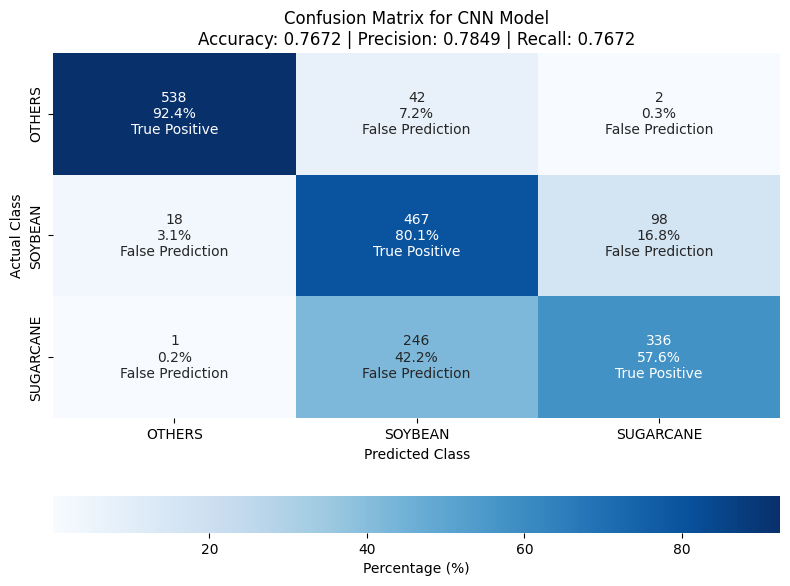


✅ Matriz de confusão salva em: /content/figura_cnn_confusion_matrix.eps


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, accuracy_score

# ========================
# 1. Preparar dados
# ========================
# Verdadeiros rótulos e predições (já definidos anteriormente)
y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen, verbose=1), axis=1)

# ========================
# 2. Calcular métricas
# ========================
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

# ========================
# 3. Formatar rótulos e porcentagens
# ========================
labels = list(train_gen.class_indices.keys())  # ['SUGARCANE', 'SOYBEAN', 'OTHERS']
row_sums = cm.sum(axis=1, keepdims=True)
percent_matrix = np.divide(cm, row_sums, where=row_sums != 0) * 100

formatted_labels = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        tipo = "True" if i == j else "False"
        classe = "Positive" if i == j else "Prediction"
        formatted_labels[i, j] = f"{cm[i, j]}\n{percent_matrix[i, j]:.1f}%\n{tipo} {classe}"

# ========================
# 4. Plotar matriz estilizada
# ========================
title = f"Confusion Matrix for CNN Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})

plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.tight_layout()

# Salvar a figura como EPS (vetorial)
output_path = "/content/figura_cnn_confusion_matrix.eps"
plt.savefig(output_path, format="eps", dpi=300)
plt.show()

print(f"\n Matriz de confusão salva em: {output_path}")


### Aqui comeca a cnn hibrida

In [11]:
df_tabular = pd.read_csv("/content/dataset_final_balanced.csv")
df_tabular.head(20)

,IMAGE,NDVI,STD_NDVI,TEXTURE_NDVI,GLCM_CONTRAST,GLCM_HOMOGENEITY,GLCM_ENERGY,GLCM_CORRELATION,NIR,RED,AREA,COMPACTNESS,ECCENTRICITY,ASPECT_RATIO,SOLIDITY,RECTANGULARITY,CLASS
0,947136.png,0.600724,0.016292,0.000265,1534.682420,0.838622,0.664848,0.888875,0.533710,0.133001,1382.0,0.153942,0.911552,1.233333,0.555466,0.311261,SUGARCANE
1,802184.png,0.596516,0.037039,0.001372,1319.691667,0.747922,0.694319,0.903933,0.487390,0.121332,1514.0,0.121472,0.929285,1.763636,0.510108,0.283786,SUGARCANE
2,469295.png,0.615383,0.004357,0.000019,NaN,NaN,NaN,NaN,0.528680,0.145640,5.0,2.317325,0.816497,1.500000,1.000000,0.833333,OTHERS
3,585905.png,0.601949,0.043873,0.001925,896.711538,0.876523,0.858046,0.875439,0.511937,0.126312,1032.0,0.116535,0.972357,0.750000,0.343542,0.127219,SUGARCANE
4,1134069.png,0.592190,0.046066,0.002122,2254.079710,0.751454,0.700241,0.832643,0.470175,0.120533,814.0,0.118547,0.896031,0.652174,0.390408,0.262158,SUGARCANE
5,341071.png,0.606238,0.023012,0.000530,1239.166092,0.827260,0.691447,0.904039,0.560719,0.137332,1011.0,0.239201,0.775161,1.051724,0.468707,0.285755,SOYBEAN
6,811071.png,0.582918,0.046887,0.002198,2156.042735,0.750864,0.710437,0.827626,0.534843,0.139176,605.0,0.120260,0.873113,1.564103,0.410448,0.254309,SUGARCANE
7,695246.png,0.605510,0.002386,0.000006,NaN,NaN,NaN,NaN,0.565900,0.144920,5.0,2.317325,0.816497,1.500000,1.000000,0.833333,OTHERS
8,610673.png,0.594100,0.047637,0.002269,1483.875329,0.711997,0.632969,0.896129,0.530382,0.135484,3146.0,0.097879,0.689573,0.641667,0.538422,0.340476,SUGARCANE
9,838105.png,0.604657,0.000000,0.000000,NaN,NaN,NaN,NaN,0.507300,0.142400,1.0,12.566371,0.000000,1.000000,1.000000,1.000000,OTHERS


In [12]:
# ========================
# 1. Instalar bibliotecas (caso necessário)
# ========================
!pip install --quiet tensorflow
# ========================
# 0. Fixar aleatoriedade para reprodutibilidade
# ========================
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# ========================
# 2. Importar pacotes
# ========================
import zipfile
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ========================
# 3. Configurações iniciais
# ========================
img_size = (32, 32)
batch_size = 32
epochs = 50

# ========================
# 4. Caminhos para dados
# ========================
zip_path = "/content/drive/MyDrive/Article_SugarCane/imagens_treinamento.zip"
unzip_path = "/content/dataset_imagens"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

train_dir = os.path.join(unzip_path, "train")
test_dir = os.path.join(unzip_path, "test")

# ========================
# 5. Data Augmentation
# ========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# ========================
# 6. Arquitetura da CNN (API Funcional)
# ========================
input_layer = Input(shape=(img_size[0], img_size[1], 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten(name='Flatten')(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.4)(x)  # Descomente se quiser usar dropout
output_layer = Dense(3, activation='softmax')(x)  # 3 classes

model = Model(inputs=input_layer, outputs=output_layer)

# ========================
# 7. Compilação
# ========================
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========================
# 8. Treinamento
# ========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[early_stop],
    verbose=1
)


Found 6991 images belonging to 3 classes.
Found 1748 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4348 - loss: 1.0405 - val_accuracy: 0.6568 - val_loss: 0.6865
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6552 - loss: 0.7132 - val_accuracy: 0.6911 - val_loss: 0.6434
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6853 - loss: 0.6771 - val_accuracy: 0.7019 - val_loss: 0.6290
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6793 - loss: 0.6634 - val_accuracy: 0.6842 - val_loss: 0.6386
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6909 - loss: 0.6573 - val_accuracy: 0.6859 - val_loss: 0.6453
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6986 - loss: 0.6388 - val_accuracy: 0.6693 - val_loss: 0.6614
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7132 - loss: 0.6181 - val_accuracy: 0.7237 - val_loss: 0.5820
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7061 - loss: 0.6127 - val_accuracy: 0.714

In [13]:

 # ativa o modelo

# ========================
# 6. Imports adicionais necessários
# ========================
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# ========================
# 7. Ativar modelo para definir input/output
# ========================
# Isso é necessário para que model.input funcione corretamente
 # executa o modelo com o primeiro batch
#model.predict(train_gen[0][0])
# ========================
# 8. Gerar embeddings
# ========================


embedding_model = Model(inputs=model.input, outputs=model.get_layer('Flatten').output)
test_gen.reset()
embeddings = embedding_model.predict(test_gen, verbose=1)

image_ids = [os.path.basename(f) for f in test_gen.filenames]
df_embeddings = pd.DataFrame(embeddings)
df_embeddings['IMAGE'] = image_ids

# ========================
# 9. Carregar dados tabulares
# ========================
df_tabular = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_balanced.csv")
df_tabular['IMAGE'] = df_tabular['IMAGE'].astype(str).str.strip()

# ========================
# 10. Combinar dados
# ========================
df_combined = pd.merge(df_tabular, df_embeddings, on="IMAGE")

# Preencher NaNs com média por classe
for col in df_combined.columns:
    if col not in ['IMAGE', 'CLASS'] and df_combined[col].isnull().any():
        df_combined[col] = df_combined.groupby('CLASS')[col].transform(lambda x: x.fillna(x.mean()))

# ========================
# 11. Preparar entradas para MLP
# ========================
cols_excluir = ['IMAGE', 'CLASS']
cols_espectrais = [col for col in df_tabular.columns if col not in cols_excluir]

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df_combined[cols_espectrais])
X_embed = df_combined.iloc[:, -embeddings.shape[1]:].values  # últimos N cols = embeddings
X = np.concatenate([X_tabular, X_embed], axis=1)
y = LabelEncoder().fit_transform(df_combined["CLASS"])

# ========================
# 12. Treinar MLP
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("treinando com MLP")
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True,
                    n_iter_no_change=10, random_state=42, verbose=1)
mlp.fit(X_train, y_train)


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
treinando com MLP
Iteration 1, loss = 0.91977335
Validation score: 0.800000
Iteration 2, loss = 0.59351643
Validation score: 0.821429
Iteration 3, loss = 0.42812876
Validation score: 0.828571
Iteration 4, loss = 0.35275639
Validation score: 0.857143
Iteration 5, loss = 0.31226824
Validation score: 0.857143
Iteration 6, loss = 0.28724586
Validation score: 0.842857
Iteration 7, loss = 0.28066462
Validation score: 0.871429
Iteration 8, loss = 0.25429919
Validation score: 0.857143
Iteration 9, loss = 0.24842328
Validation score: 0.871429
Iteration 10, loss = 0.24095576
Validation score: 0.850000
Iteration 11, loss = 0.23016843
Validation score: 0.857143
Iteration 12, loss = 0.22768412
Validation score: 0.864286
Iteration 13, loss = 0.21822160
Validation score: 0.850000
Iteration 14, loss = 0.21558856
Validation score: 0.864286
Iteration 15, loss = 0.21636281
Validation score: 0.864286
Iteration 16, loss = 0.20798160
Validation score: 0.850000
Iterati

MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64), max_iter=500,
              random_state=42, verbose=1)

In [ ]:
from sklearn.metrics import classification_report
# ========================
# 11. Avaliação
# ========================
y_pred = mlp.predict(X_test)
print("\n Relatório de desempenho da MLP:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(df_combined["CLASS"]).classes_))


📊 Relatório de desempenho da MLP:
              precision    recall  f1-score   support

      OTHERS       0.99      0.97      0.98       116
     SOYBEAN       0.81      0.82      0.81       117
   SUGARCANE       0.80      0.80      0.80       117

    accuracy                           0.86       350
   macro avg       0.86      0.86      0.86       350
weighted avg       0.86      0.86      0.86       350



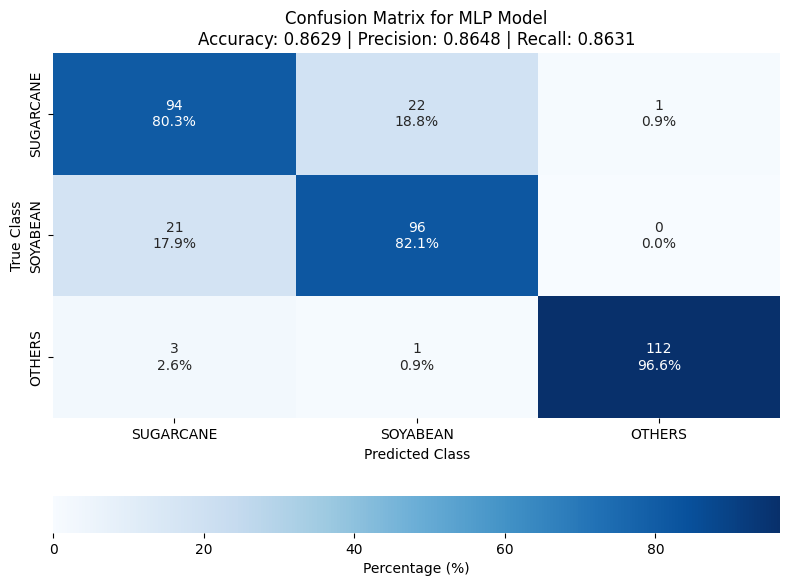

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ========================
# 4. Styled Confusion Matrix with Custom Labels
# ========================

# Readable class names for display
label_names = ['SUGARCANE', 'SOYABEAN', 'OTHERS']
class_mapping = {'SUGARCANE': 'SUGARCANE', 'SOYABEAN': 'SOYABEAN', 'OTHERS': 'OTHERS'}

# Re-encode y_test and y_pred if needed
le = LabelEncoder()
le.fit(['SUGARCANE', 'SOYABEAN', 'OTHERS'])  # Order must match your model
y_test_named = le.inverse_transform(y_test)
y_pred_named = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test_named, y_pred_named, labels=['SUGARCANE', 'SOYABEAN', 'OTHERS'])

# Compute row-wise percentages
percent_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
formatted_labels = np.array([
    ["{0}\n{1:.1f}%".format(val, perc) for val, perc in zip(row_cm, row_percent)]
    for row_cm, row_percent in zip(cm, percent_matrix)
])

# Evaluation metrics
accuracy = accuracy_score(y_test_named, y_pred_named)
precision = precision_score(y_test_named, y_pred_named, average='macro', zero_division=0)
recall = recall_score(y_test_named, y_pred_named, average='macro', zero_division=0)

# Title with metrics
title = f"Confusion Matrix for MLP Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})

plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()

# Save as EPS
plt.savefig("confusion_matrix_mlp.eps", format='eps')
plt.show()


In [14]:
# ========================
# 1. Install TensorFlow
# ========================
!pip install --quiet tensorflow

# ========================
# 2. Reproducibility
# ========================
import os
import random
import numpy as np
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ========================
# 3. Import Packages
# ========================
import zipfile
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ========================
# 4. Configurations
# ========================
img_size = (32, 32)
batch_size = 32
epochs = 50

# ========================
# 5. Load and Unzip Data
# ========================
zip_path = "/content/drive/MyDrive/Article_SugarCane/imagens_treinamento.zip"
unzip_path = "/content/dataset_imagens"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

train_dir = os.path.join(unzip_path, "train")
test_dir = os.path.join(unzip_path, "test")

# ========================
# 6. Data Augmentation
# ========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

# ========================
# 7. CNN Architecture (Functional API)
# ========================
input_layer = Input(shape=(img_size[0], img_size[1], 1))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten(name='Flatten')(x)
x = Dense(128, activation='relu')(x)
# x = Dropout(0.4)(x)  # Optional dropout
output_layer = Dense(3, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# ========================
# 8. Compile and Train
# ========================
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    callbacks=[early_stop],
    verbose=1
)


Found 6991 images belonging to 3 classes.
Found 1748 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4348 - loss: 1.0405 - val_accuracy: 0.6568 - val_loss: 0.6865
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6552 - loss: 0.7132 - val_accuracy: 0.6911 - val_loss: 0.6434
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6853 - loss: 0.6771 - val_accuracy: 0.7019 - val_loss: 0.6290
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6793 - loss: 0.6634 - val_accuracy: 0.6842 - val_loss: 0.6386
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6909 - loss: 0.6573 - val_accuracy: 0.6859 - val_loss: 0.6453
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6986 - loss: 0.6388 - val_accuracy: 0.6693 - val_loss: 0.6614
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7132 - loss: 0.6181 - val_accuracy: 0.7237 - val_loss: 0.5820
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7061 - loss: 0.6127 - val_accuracy: 0.714

In [15]:
# ========================
# 1. Imports
# ========================
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

# ========================
# 2. Generate Embeddings for Train
# ========================
embedding_model = Model(inputs=model.input, outputs=model.get_layer('Flatten').output)

train_gen.reset()
train_embeddings = embedding_model.predict(train_gen, verbose=1)
train_image_ids = [os.path.basename(f) for f in train_gen.filenames]
df_train_embeddings = pd.DataFrame(train_embeddings)
df_train_embeddings['IMAGE'] = train_image_ids

# ========================
# 3. Generate Embeddings for Test
# ========================
test_gen.reset()
test_embeddings = embedding_model.predict(test_gen, verbose=1)
test_image_ids = [os.path.basename(f) for f in test_gen.filenames]
df_test_embeddings = pd.DataFrame(test_embeddings)
df_test_embeddings['IMAGE'] = test_image_ids

# ========================
# 4. Combine All Embeddings
# ========================
df_embeddings = pd.concat([df_train_embeddings, df_test_embeddings], ignore_index=True)

# ========================
# 5. Load Tabular Data
# ========================
df_tabular = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final_balanced.csv")
df_tabular['IMAGE'] = df_tabular['IMAGE'].astype(str).str.strip()

# ========================
# 6. Merge Tabular and Embeddings
# ========================
df_combined = pd.merge(df_tabular, df_embeddings, on="IMAGE")

# Fill NaNs with class-wise mean
for col in df_combined.columns:
    if col not in ['IMAGE', 'CLASS'] and df_combined[col].isnull().any():
        df_combined[col] = df_combined.groupby('CLASS')[col].transform(lambda x: x.fillna(x.mean()))

# ========================
# 7. Prepare Data for MLP
# ========================
cols_exclude = ['IMAGE', 'CLASS']
cols_tabular = [col for col in df_tabular.columns if col not in cols_exclude]

scaler = StandardScaler()
X_tabular = scaler.fit_transform(df_combined[cols_tabular])
X_embed = df_combined.iloc[:, -train_embeddings.shape[1]:].values  # assumes embeddings are at the end
X = np.concatenate([X_tabular, X_embed], axis=1)
y = LabelEncoder().fit_transform(df_combined["CLASS"])

# ========================
# 8. Train MLP
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training MLP...")
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, early_stopping=True,
                    n_iter_no_change=10, random_state=42, verbose=1)
mlp.fit(X_train, y_train)


219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Training MLP...
Iteration 1, loss = 0.62035620
Validation score: 0.847143
Iteration 2, loss = 0.34953672
Validation score: 0.878571
Iteration 3, loss = 0.31066448
Validation score: 0.864286
Iteration 4, loss = 0.28647645
Validation score: 0.885714
Iteration 5, loss = 0.27345808
Validation score: 0.865714
Iteration 6, loss = 0.26500580
Validation score: 0.887143
Iteration 7, loss = 0.26020937
Validation score: 0.885714
Iteration 8, loss = 0.25488437
Validation score: 0.890000
Iteration 9, loss = 0.24511307
Validation score: 0.895714
Iteration 10, loss = 0.24573468
Validation score: 0.890000
Iteration 11, loss = 0.23492353
Validation score: 0.891429
Iteration 12, loss = 0.22857011
Validation score: 0.901429
Iteration 13, loss = 0.22325680
Validation score: 0.891429
Iteration 14, loss = 0.22640640
Validation score: 0.890000
Iteration 15, loss = 0.22602641
Validation score: 0.884286
Iteration 16, loss = 0.218

MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64), max_iter=500,
              random_state=42, verbose=1)

In [ ]:
from sklearn.metrics import classification_report
# ========================
# 11. Avaliação
# ========================
y_pred = mlp.predict(X_test)
print("\n Relatório de desempenho da MLP:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(df_combined["CLASS"]).classes_))


📊 Relatório de desempenho da MLP:
              precision    recall  f1-score   support

      OTHERS       1.00      0.99      0.99       582
     SOYBEAN       0.82      0.86      0.84       583
   SUGARCANE       0.85      0.82      0.83       583

    accuracy                           0.89      1748
   macro avg       0.89      0.89      0.89      1748
weighted avg       0.89      0.89      0.89      1748



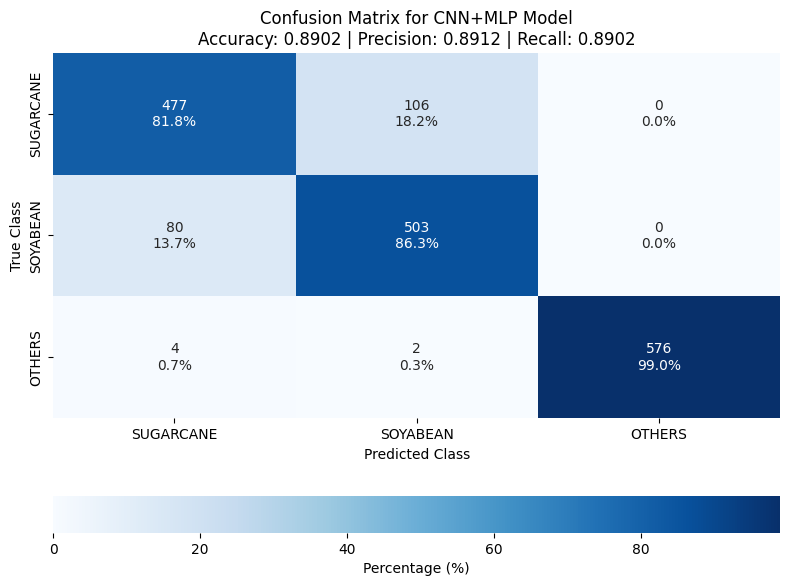

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ========================
# 4. Styled Confusion Matrix with Custom Labels
# ========================

# Readable class names for display
label_names = ['SUGARCANE', 'SOYABEAN', 'OTHERS']
class_mapping = {'SUGARCANE': 'SUGARCANE', 'SOYABEAN': 'SOYABEAN', 'OTHERS': 'OTHERS'}

# Re-encode y_test and y_pred if needed
le = LabelEncoder()
le.fit(['SUGARCANE', 'SOYABEAN', 'OTHERS'])  # Order must match your model
y_test_named = le.inverse_transform(y_test)
y_pred_named = le.inverse_transform(y_pred)

cm = confusion_matrix(y_test_named, y_pred_named, labels=['SUGARCANE', 'SOYABEAN', 'OTHERS'])

# Compute row-wise percentages
percent_matrix = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
formatted_labels = np.array([
    ["{0}\n{1:.1f}%".format(val, perc) for val, perc in zip(row_cm, row_percent)]
    for row_cm, row_percent in zip(cm, percent_matrix)
])

# Evaluation metrics
accuracy = accuracy_score(y_test_named, y_pred_named)
precision = precision_score(y_test_named, y_pred_named, average='macro', zero_division=0)
recall = recall_score(y_test_named, y_pred_named, average='macro', zero_division=0)

# Title with metrics
title = f"Confusion Matrix for CNN+MLP Model\nAccuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}"

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(percent_matrix, annot=formatted_labels, fmt='', cmap="Blues", cbar=True,
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'orientation': 'horizontal', 'label': 'Percentage (%)'})

plt.title(title)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()

# Save as EPS
plt.savefig("confusion_matrix_mlp.eps", format='eps')
plt.show()


In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,171 (1.82 MB)

 Trainable params: 158,723 (620.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 317,448 (1.21 MB)

In [ ]:
print("=== MLP Architecture ===")
print(f"Hidden layers: {mlp.hidden_layer_sizes}")

# Número de features de entrada
n_input = mlp.coefs_[0].shape[0]
print(f"Number of input features: {n_input}\n")

for i, (weights, bias) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
    n_neurons = weights.shape[1]
    n_weights = weights.size
    n_bias = bias.size
    print(f"Layer {i + 1}:")
    print(f" - Input shape: {weights.shape[0]}")
    print(f" - Neurons: {n_neurons}")
    print(f" - Weights shape: {weights.shape}")
    print(f" - Trainable weights: {n_weights}")
    print(f" - Trainable biases: {n_bias}")
    print()


=== MLP Architecture ===
Hidden layers: (128, 64)
Number of input features: 527

Layer 1:
 - Input shape: 527
 - Neurons: 128
 - Weights shape: (527, 128)
 - Trainable weights: 67456
 - Trainable biases: 128

Layer 2:
 - Input shape: 128
 - Neurons: 64
 - Weights shape: (128, 64)
 - Trainable weights: 8192
 - Trainable biases: 64

Layer 3:
 - Input shape: 64
 - Neurons: 3
 - Weights shape: (64, 3)
 - Trainable weights: 192
 - Trainable biases: 3



In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv")
contagem_por_classe = df["CLASS"].value_counts()
print(contagem_por_classe)

CLASS
OTHERS       1140965
SUGARCANE      16481
SOYBEAN         4802
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Carregar o dataset
df = pd.read_csv('/content/drive/MyDrive/Article_SugarCane/dataset_final3.csv')

# Exibir todos os nomes das colunas
print(df.columns.tolist())

['IMAGE', 'NDVI', 'STD_NDVI', 'TEXTURE_NDVI', 'GLCM_CONTRAST', 'GLCM_HOMOGENEITY', 'GLCM_ENERGY', 'GLCM_CORRELATION', 'NIR', 'RED', 'AREA', 'COMPACTNESS', 'ECCENTRICITY', 'ASPECT_RATIO', 'SOLIDITY', 'RECTANGULARITY', 'CLASS']


In [18]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.7 MB/s eta 0:00:00


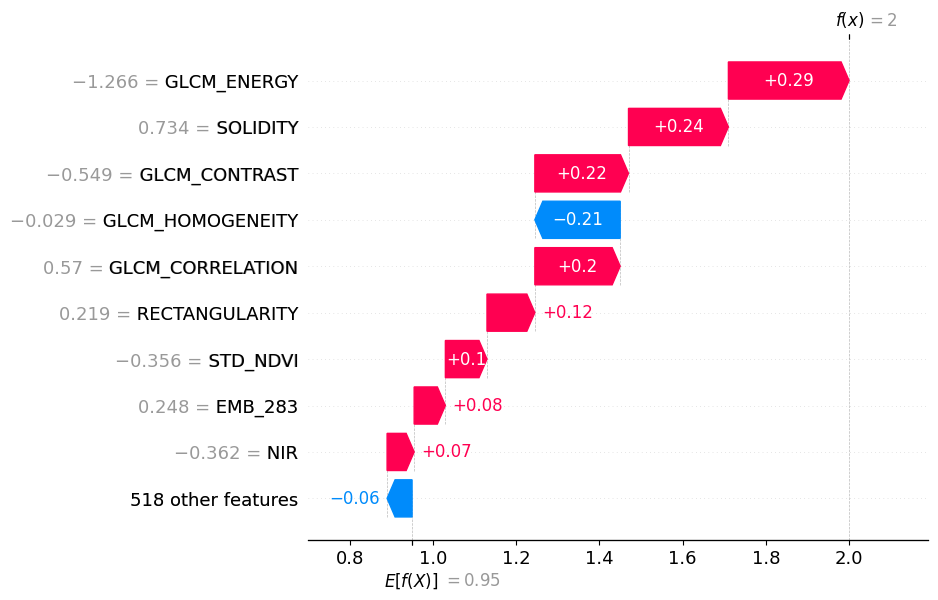

In [25]:
import shap
import matplotlib.pyplot as plt



# Nomes reais das variáveis tabulares
cols_tabular = [col for col in df_tabular.columns if col not in ['IMAGE', 'CLASS']]

# Nomes para os embeddings
n_embed = train_embeddings.shape[1]
embedding_names = [f'EMB_{i}' for i in range(n_embed)]

# Combina todos os nomes
feature_names = cols_tabular + embedding_names

# Cria o explicador
explainer = shap.Explainer(mlp.predict, X_train, feature_names=feature_names, max_evals=2*len(feature_names)+1)

# Seleciona uma amostra
X_sample = X_test[0:1]

# Calcula SHAP
shap_values = explainer(X_sample)

# Gráfico com nomes reais
shap.plots.waterfall(shap_values[0])

fig = plt.figure()
shap.plots.waterfall(shap_values[0], show=False)
plt.tight_layout()
plt.savefig("shap_waterfall.eps", format='eps')
plt.close()
